## Step 1: Set Up the RawBoost Augmentation Code

In [ ]:
'''
#### In Terminal run
$ git clone https://github.com/TakHemlata/RawBoost-antispoofing.git
$ conda create --name RawBoost_antispoofing python=3.8.8
#---------------------------------------
$ conda activate RawBoost_antispoofing
#---------------------------------------
$ conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c nvidia

# This is where the repo was cloned
cd C:\Users\User\RawBoost-antispoofing
$ pip install -r requirements.txt
'''

In [3]:
###############
# RawBoost.py #
###############

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from scipy import signal
import copy


def randRange(x1, x2, integer):
    y = np.random.uniform(low=x1, high=x2, size=(1,))
    if integer:
        y = int(y)
    return y

def normWav(x,always):
    if always:
        x = x/np.amax(abs(x))
    elif np.amax(abs(x)) > 1:
            x = x/np.amax(abs(x))
    return x



def genNotchCoeffs(nBands,minF,maxF,minBW,maxBW,minCoeff,maxCoeff,minG,maxG,fs):
    b = 1
    for i in range(0, nBands):
        fc = randRange(minF,maxF,0);
        bw = randRange(minBW,maxBW,0);
        c = randRange(minCoeff,maxCoeff,1);
          
        if c/2 == int(c/2):
            c = c + 1
        f1 = fc - bw/2
        f2 = fc + bw/2
        if f1 <= 0:
            f1 = 1/1000
        if f2 >= fs/2:
            f2 =  fs/2-1/1000
        b = np.convolve(signal.firwin(c, [float(f1), float(f2)], window='hamming', fs=fs),b)

    G = randRange(minG,maxG,0); 
    _, h = signal.freqz(b, 1, fs=fs)    
    b = pow(10, G/20)*b/np.amax(abs(h))   
    return b


def filterFIR(x,b):
    N = b.shape[0] + 1
    xpad = np.pad(x, (0, N), 'constant')
    y = signal.lfilter(b, 1, xpad)
    y = y[int(N/2):int(y.shape[0]-N/2)]
    return y

# Linear and non-linear convolutive noise
def LnL_convolutive_noise(x,N_f,nBands,minF,maxF,minBW,maxBW,minCoeff,maxCoeff,minG,maxG,minBiasLinNonLin,maxBiasLinNonLin,fs):
    y = [0] * x.shape[0]
    for i in range(0, N_f):
        if i == 1:
            minG = minG-minBiasLinNonLin;
            maxG = maxG-maxBiasLinNonLin;
        b = genNotchCoeffs(nBands,minF,maxF,minBW,maxBW,minCoeff,maxCoeff,minG,maxG,fs)
        y = y + filterFIR(np.power(x, (i+1)),  b)     
    y = y - np.mean(y)
    y = normWav(y,0)
    return y


# Impulsive signal dependent noise
def ISD_additive_noise(x, P, g_sd):
    beta = randRange(0, P, 0)
    
    y = copy.deepcopy(x)
    x_len = x.shape[0]
    n = int(x_len*(beta/100))
    p = np.random.permutation(x_len)[:n]
    f_r= np.multiply(((2*np.random.rand(p.shape[0]))-1),((2*np.random.rand(p.shape[0]))-1))
    r = g_sd * x[p] * f_r
    y[p] = x[p] + r
    y = normWav(y,0)
    return y


# Stationary signal independent noise

def SSI_additive_noise(x,SNRmin,SNRmax,nBands,minF,maxF,minBW,maxBW,minCoeff,maxCoeff,minG,maxG,fs):
    noise = np.random.normal(0, 1, x.shape[0])
    b = genNotchCoeffs(nBands,minF,maxF,minBW,maxBW,minCoeff,maxCoeff,minG,maxG,fs)
    noise = filterFIR(noise, b)
    noise = normWav(noise,1)
    SNR = randRange(SNRmin, SNRmax, 0)
    noise = noise / np.linalg.norm(noise,2) * np.linalg.norm(x,2) / 10.0**(0.05 * SNR)
    x = x + noise
    return x

In [ ]:
# %pip install numpy torch librosa

In [4]:
##########################
# data_utils_rawboost.py #
##########################
import os, sys
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import librosa
from torch.utils.data import Dataset
from librosa import effects
import random

# Needs Dynamic Module Import or juts run the RawBoost.py before this
# from RawBoost import ISD_additive_noise,LnL_convolutive_noise,SSI_additive_noise,normWav

___author__ = "Hemlata Tak, Massimiliano Todisco"
__email__ = "{tak,todisco}@eurecom.fr"


#--------------RawBoost data augmentation algorithms---------------------------##

def process_Rawboost_feature(feature, sr,args,algo):
    
    # Data process by Convolutive noise (1st algo)
    if algo==1:

        feature =LnL_convolutive_noise(feature,args.N_f,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,args.minCoeff,args.maxCoeff,args.minG,args.maxG,args.minBiasLinNonLin,args.maxBiasLinNonLin,sr)
                            
    # Data process by Impulsive noise (2nd algo)
    elif algo==2:
        
        feature=ISD_additive_noise(feature, args.P, args.g_sd)
                            
    # Data process by coloured additive noise (3rd algo)
    elif algo==3:
        
        feature=SSI_additive_noise(feature,args.SNRmin,args.SNRmax,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,args.minCoeff,args.maxCoeff,args.minG,args.maxG,sr)
    
    # Data process by all 3 algo. together in series (1+2+3)
    elif algo==4:
        
        feature =LnL_convolutive_noise(feature,args.N_f,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,
                 args.minCoeff,args.maxCoeff,args.minG,args.maxG,args.minBiasLinNonLin,args.maxBiasLinNonLin,sr)                         
        feature=ISD_additive_noise(feature, args.P, args.g_sd)  
        feature=SSI_additive_noise(feature,args.SNRmin,args.SNRmax,args.nBands,args.minF,
                args.maxF,args.minBW,args.maxBW,args.minCoeff,args.maxCoeff,args.minG,args.maxG,sr)                 

    # Data process by 1st two algo. together in series (1+2)
    elif algo==5:
        
        feature =LnL_convolutive_noise(feature,args.N_f,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,
                 args.minCoeff,args.maxCoeff,args.minG,args.maxG,args.minBiasLinNonLin,args.maxBiasLinNonLin,sr)                         
        feature=ISD_additive_noise(feature, args.P, args.g_sd)                
                            

    # Data process by 1st and 3rd algo. together in series (1+3)
    elif algo==6:  
        
        feature =LnL_convolutive_noise(feature,args.N_f,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,
                 args.minCoeff,args.maxCoeff,args.minG,args.maxG,args.minBiasLinNonLin,args.maxBiasLinNonLin,sr)                         
        feature=SSI_additive_noise(feature,args.SNRmin,args.SNRmax,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,args.minCoeff,args.maxCoeff,args.minG,args.maxG,sr) 

    # Data process by 2nd and 3rd algo. together in series (2+3)
    elif algo==7: 
        
        feature=ISD_additive_noise(feature, args.P, args.g_sd)
        feature=SSI_additive_noise(feature,args.SNRmin,args.SNRmax,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,args.minCoeff,args.maxCoeff,args.minG,args.maxG,sr) 
   
    # Data process by 1st two algo. together in Parallel (1||2)
    elif algo==8:
        
        feature1 =LnL_convolutive_noise(feature,args.N_f,args.nBands,args.minF,args.maxF,args.minBW,args.maxBW,
                 args.minCoeff,args.maxCoeff,args.minG,args.maxG,args.minBiasLinNonLin,args.maxBiasLinNonLin,sr)                         
        feature2=ISD_additive_noise(feature, args.P, args.g_sd)

        feature_para=feature1+feature2
        feature=normWav(feature_para,0)  #normalized resultant waveform
 
    # original data without Rawboost processing           
    else:
        
        feature=feature
    
    return feature


def genSpoof_list( dir_meta,is_train=False,is_eval=False):
    
    d_meta = {}
    file_list=[]
    with open(dir_meta, 'r') as f:
         l_meta = f.readlines()

    if (is_train):
        for line in l_meta:
             _, key,_,_,label = line.strip().split(' ')
             file_list.append(key)
             d_meta[key] = 1 if label == 'bonafide' else 0
        return d_meta,file_list
    
    elif(is_eval):
        for line in l_meta:
            key= line.strip()
            file_list.append(key)
        return file_list
    else:
        for line in l_meta:
             _, key,_,_,label = line.strip().split(' ')
             file_list.append(key)
             d_meta[key] = 1 if label == 'bonafide' else 0
        return d_meta,file_list



def pad(x, max_len=64600):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    # need to pad
    num_repeats = int(max_len / x_len)+1
    padded_x = np.tile(x, (1, num_repeats))[:, :max_len][0]
    return padded_x	
			

class Dataset_ASVspoof2019_train(Dataset):
	def __init__(self,args,list_IDs, labels, base_dir,algo):
            '''self.list_IDs	: list of strings (each string: utt key),
               self.labels      : dictionary (key: utt key, value: label integer)'''
               
            self.list_IDs = list_IDs
            self.labels = labels
            self.base_dir = base_dir
            self.algo=algo
            self.args=args
            self.cut=64600 # take ~4 sec audio (64600 samples)

	def __len__(self):
           return len(self.list_IDs)


	def __getitem__(self, index):
            
            key = self.list_IDs[index]
            X,fs = librosa.load(self.base_dir+'flac/'+key+'.flac', sr=16000) 
            Y=process_Rawboost_feature(X,fs,self.args,self.algo)
            X_pad= pad(Y,self.cut)
            x_inp= Tensor(X_pad)
            y = self.labels[key]
            
            return x_inp, y

            
            
class Dataset_ASVspoof2021_eval(Dataset):
	def __init__(self, list_IDs, base_dir):
            '''self.list_IDs	: list of strings (each string: utt key),
               '''
               
            self.list_IDs = list_IDs
            self.base_dir = base_dir
            self.cut=64600 # take ~4 sec audio (64600 samples)

	def __len__(self):
            return len(self.list_IDs)


	def __getitem__(self, index):
            
            key = self.list_IDs[index]
            X, fs = librosa.load(self.base_dir+'flac/'+key+'.flac', sr=16000)
            X_pad = pad(X,self.cut)
            x_inp = Tensor(X_pad)
            return x_inp,key           



## Step 2: Define Augmentation Parameters and Setup

In [5]:
class AugmentArgs:
    def __init__(self):
        self.N_f = 2  # Example parameter for LnL convolutive noise
        self.nBands = 3
        self.minF = 100
        self.maxF = 8000
        self.minBW = 50
        self.maxBW = 500
        self.minCoeff = 10
        self.maxCoeff = 20
        self.minG = -10
        self.maxG = 0
        self.minBiasLinNonLin = 1
        self.maxBiasLinNonLin = 3
        self.P = 30  # Example parameter for ISD additive noise
        self.g_sd = 0.8
        self.SNRmin = 0  # Example parameter for SSI additive noise
        self.SNRmax = 30

args = AugmentArgs()


## Step 3: Data Cleaning (ASVspoof got it all wrong!!!)

From 2019 dataset we keep the LA train and dev flac files and also their metadata.
From 2021 dataset we keep the LA eval flac files (The metadata here are shit!)
From keys_2021 we keep the LA/CM eval trail_metadata
From keys_2021 we keep the LA/CM/LFCC-LCNN eval scores (cm scores)


* Train 2019 Dataset flac = C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac
* Train 2019 metadata = C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn

* Train 2019 Dataset flac = C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac
* Dev 2019 metadata = C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl



Going to a more "recent" eval set for state of the art
* Eval 2021 Dataset flac = C:\Users\User\Desktop\Original_ASV_Data\ASVspoof2021_LA_eval
* Eval 2021 metadata = C:\Users\User\Desktop\Original_ASV_Data\keys\LA\CM\trial_metadata.txt
* Eval 2021 cm scores = C:\Users\User\Desktop\Original_ASV_Data\keys\LA\CM\LFCC-LCNN\score.txt

In [2]:
'''
train_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac'
dev_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac'
eval_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\ASVspoof2021_LA_eval\flac'


train_meta = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'
dev_meta = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
eval_meta_shit = r'C:\Users\User\Desktop\Original_ASV_Data\keys\LA\CM\trial_metadata.txt'

eval_cm_scores = r'C:\Users\User\Desktop\Original_ASV_Data\keys\LA\CM\LFCC-LCNN\score.txt'

# Don't forget to add the ".txt" at the end of the metadata
'''

### Eval metadata problem

The EVAL metadata for 2021 follows a different structure   
compared to previous datasets. As a result, we need to     
adapt the parsing logic accordingly. Specifically,         
certain columns like spoof indicators or file names may be 
located in different positions within the metadata lines.  
Therefore, this section of the script will handle these    
differences and reformat the metadata into the desired     
structure, consistent with earlier datasets.  

In [ ]:
# Path to the input file (first form) and new output file (desired form)
eval_meta_original = r'C:/Users/User/Desktop/Original_ASV_Data/keys/LA/CM/trial_metadata.txt'  # Eval metadata

# Path to the new location for the output file
eval_meta_correct = r'C:/Users/User/Desktop/Processed_ASV_Data/Eval_CM_2021_Metadata/correct_eval_metadata.txt'

# Open the input file and new output file
with open(eval_meta_original, 'r') as infile, open(eval_meta_correct, 'w') as outfile:
    # Iterate through each line in the input file
    for line in infile:
        parts = line.strip().split()  # Split the line into parts based on spaces
        
        # Extract the required columns
        col1 = parts[0]  # First column (e.g., LA_0009)
        col2 = parts[1]  # Second column (e.g., LA_E_4562098)
        col3 = '-'  # Always '-'
        col5 = parts[4]  # Fifth column (e.g., 'A07' in spoof or '-' in bonafide)
        col7 = parts[5]  # Last column (e.g., spoof or bonafide)

        # Handle missing values (convert 'none' to '-')
        if col7 == 'spoof':
            col5 = col5  # Keep col5 for spoof
        else:
            col5 = '-'  # Set col5 to '-' for bonafide

        # Format the line into the desired output format
        new_line = f"{col1} {col2} {col3} {col5} {col7}\n"
        
        # Write the formatted line to the new output file
        outfile.write(new_line)

print(f"File has been transformed successfully and saved to {eval_meta_correct}!")

Also print the line of each metadata type to make sure they all align

In [ ]:
# Define the paths for train and eval metadata files
train_meta = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'
dev_meta = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
eval_meta_correct = r'C:/Users/User/Desktop/Processed_ASV_Data/Eval_CM_2021_Metadata/correct_eval_metadata.txt'
eval_meta_original = r'C:/Users/User/Desktop/Original_ASV_Data/keys/LA/CM/trial_metadata.txt'  

# Function to read the first line from a file
def fetch_first_line(file_path):
    with open(file_path, 'r') as file:
        first_line = file.readline().strip()  # Read and strip whitespace
    return first_line

# Fetch one line from train and eval metadata files
train_line = fetch_first_line(train_meta)
dev_line = fetch_first_line(dev_meta)
eval_line = fetch_first_line(eval_meta_correct)
eval_shit = fetch_first_line(eval_meta_original)



# Print the lines for comparison
print(f"First line from Train Metadata:\n{train_line}\n")
print(f"First line from Train Metadata:\n{dev_line}\n")
print(f"First line from Eval Correct Metadata:\n{eval_line}\n")
print(f"First line from Eval Shit Metadata:\n{eval_shit}\n")

I have a directory that contains several FLAC files, each named following a pattern like LA_T_1000137. Additionally, I have a metadata.txt file where each line is structured as follows:

* For bonafide files: LA_0079 LA_T_1138215 - - bonafide
* For spoofed files: LA_0094 LA_T_1000137 - A04 spoof

In this format:

* The second field (e.g., LA_T_1138215) corresponds to the FLAC file names.
* The fifth field indicates whether the file is bonafide (bonafide) or spoofed (spoof).

I would like to verify if every FLAC file name in the directory is present in the metadata file and print the names of those that are missing. Similarly, I would also like to check if every file listed in the metadata exists in the FLAC directory, and print any discrepancies.

In [ ]:
###############################
# Estimated Runtime: 5:10 min #
###############################
import os

# Function to get the FLAC filenames (without extensions) from a directory
def get_flac_filenames(directory):
    return [os.path.splitext(f)[0] for f in os.listdir(directory) if f.endswith('.flac')]

# Function to extract names from the metadata file
def get_metadata_filenames(metadata_file):
    metadata_names = set()  # Use a set for faster lookup
    with open(metadata_file, 'r') as file:
        for line in file:
            parts = line.strip().split()  # Split line into parts
            if len(parts) > 1:
                metadata_names.add(parts[1])  # The second column contains the filenames (like LA_T_1000137)
    return metadata_names

# Function to compare FLAC filenames with metadata
def compare_files(flac_directory, metadata_file):
    flac_files = get_flac_filenames(flac_directory)  # Get FLAC filenames from the directory
    metadata_names = get_metadata_filenames(metadata_file)  # Get metadata filenames from the metadata file
    
    # Find FLAC files that are not in the metadata
    missing_in_metadata = [f for f in flac_files if f not in metadata_names]
    
    # Find metadata files that are not in the flac directory
    missing_in_flac = [m for m in metadata_names if m not in flac_files]

    # Display results
    if missing_in_metadata:
        print(f"The following FLAC files in {flac_directory} are not in the metadata:")
        for missing in missing_in_metadata:
            print(missing)
    else:
        print(f"All FLAC files in {flac_directory} are included in the metadata.")

    if missing_in_flac:
        print(f"The following files in the metadata are missing in the FLAC directory {flac_directory}:")
        for missing in missing_in_flac:
            print(missing)
    else:
        print(f"All files in the metadata are present in the FLAC directory {flac_directory}.")

# Define your directories and metadata file paths
train_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac'
dev_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac'
eval_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\ASVspoof2021_LA_eval\flac'

train_meta = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'
dev_meta = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
eval_meta_correct = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'

# Run comparison checks for train, dev, and eval sets
print("Find inconsistencies between the metadata text file and flac diectory.")
print("For the Training Dataset")
compare_files(train_data_dir, train_meta)
print(' ')
print(' ')
print("For the Development Dataset")
compare_files(dev_data_dir, dev_meta)
print(' ')
print(' ')
print("For the Evaluation Dataset")
compare_files(eval_data_dir, eval_meta_correct)

In [ ]:
# From DEV, create a new datset that remove the D_Anum 
# (Or in the file that cmbine them ONLY copy the LA_D flac)

# Search all thetrain numvesr not include in the originla dta anc create a ist
# This list is the potenirla nams of rth eaugmneetd file (insted of calling the num_aug)

# Make sure to update the metadaa file (the have the same values as the original)

We will sort the metadata file of train, dev and eval based on the FLAC field number, in order to be more easily readable for later use

In [ ]:
# Input file path and output file path

def sort_meta_file(input_file_dir, output_file_dir):
    """
    Sorts the lines of a file based on the numeric part of the LA_T number and writes the sorted content to an output file.

    Args:
        input_file_dir (str): Path to the input file (containing the unsorted lines).
        output_file_dir (str): Path to the output file (where the sorted lines will be written).
    
    Returns:
        str: Confirmation message that the file has been sorted and written.
    """
    # Read the file and split lines into a list
    with open(input_file_dir, 'r') as f:
        lines = f.readlines()

    # Sort the lines based on the LA_T number part (second column, split by underscores)
    sorted_lines = sorted(lines, key=lambda x: int(x.split()[1].split('_')[2]))

    # Write the sorted lines into the output file
    with open(output_file_dir, 'w') as f_out:
        f_out.writelines(sorted_lines)

    return f"File has been sorted and written to {output_file_dir}"

# Example usage:
original_meta_train_unsort = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'
proccesed_meta_train_sort = r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\train_meta_sort.txt'

original_meta_dev_unsort = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
proccesed_meta_dev_sort  = r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\dev_meta_sort.txt'

corrected_meta_eval_unsort = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'
proccesed_meta_eval_sort  = r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\eval_meta_sort.txt'

# Call the function to sort the file
result_sort_train = sort_meta_file(original_meta_train_unsort, proccesed_meta_train_sort)
result_sort_dev = sort_meta_file(original_meta_dev_unsort, proccesed_meta_dev_sort)
result_sort_eval = sort_meta_file(corrected_meta_eval_unsort, proccesed_meta_eval_sort)
#########
print(result_sort_train)
print(result_sort_dev)
print(result_sort_eval)

Make sure that during sortin nothing went wrong (check if ALL line between original and sorted are the same but not in the same order)

In [ ]:
def compare_files(original_file_dir, sorted_file_dir):
    """
    Compares the original file and sorted file by checking if any lines are missing or mismatched.

    Args:
        original_file_dir (str): Path to the original metadata file.
        sorted_file_dir (str): Path to the sorted metadata file.

    Returns:
        str: A message indicating whether any entries are missing or if all match.
    """

    # Function to read and clean lines from a file (removes whitespace)
    def read_lines(file_path):
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
        return lines

    # Read lines from original and sorted files
    original_lines = read_lines(original_file_dir)
    sorted_lines = read_lines(sorted_file_dir)

    # Convert lists to sets for comparison
    original_set = set(original_lines)
    sorted_set = set(sorted_lines)

    # Check for missing or mismatched entries
    missing_in_sorted = original_set - sorted_set
    missing_in_original = sorted_set - original_set

    result = []
    
    if missing_in_sorted:
        result.append(f"Entries missing in the sorted file:\n{missing_in_sorted}")
    if missing_in_original:
        result.append(f"Entries missing in the original file:\n{missing_in_original}")

    # If no differences were found, then everything matches
    if not result:
        return "All entries match, nothing is missing."
    else:
        return "\n".join(result)


# Example usage:
original_meta_train = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'
sorted_meta_train = r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\train_meta_sort.txt'

original_meta_dev = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
sorted_meta_dev = r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\dev_meta_sort.txt'

correcetd_meta_eval = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'
sorted_meta_eval = r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\eval_meta_sort.txt'

# Compare files
result_train = compare_files(original_meta_train, sorted_meta_train)
result_dev = compare_files(original_meta_dev, sorted_meta_dev)
result_eval = compare_files(correcetd_meta_eval, sorted_meta_eval)

# Print results
print(result_train)
print(result_dev)
print(result_eval)


Make a list containing the numbers of flac field files in the flac directory

In [ ]:
import os
import re

def extract_file_numbers(directory, prefix, exclude_prefix=None, extension='.flac'):
    """
    Extracts the numeric parts from filenames in a given directory based on a prefix and optional exclusion prefix.
    
    Args:
        directory (str): The directory containing the files.
        prefix (str): The prefix to match filenames.
        exclude_prefix (str, optional): A prefix to exclude from filenames. Defaults to None.
        extension (str, optional): The file extension to filter by. Defaults to '.flac'.
    
    Returns:
        list: A sorted list of numeric parts from the filenames.
    """
    # Initialize a list to store the numeric parts of the filenames
    numbers = []

    # Define a regex pattern to match the numeric part after the prefix
    pattern = re.compile(rf'{prefix}_(\d+)')

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Check if the file name starts with the given prefix and ends with the specified extension
        if filename.startswith(prefix) and filename.endswith(extension):
            # Optionally exclude files with a specific prefix
            if exclude_prefix and filename.startswith(exclude_prefix):
                continue

            # Search for the numeric part in the filename
            match = pattern.search(filename)
            if match:
                # Extract the numeric part and add it to the list
                numbers.append(match.group(1))

    # Sort the list of numbers
    numbers.sort()

    return numbers

# Example usage for 'LA_T' in the train data directory
train_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac'
la_t_numbers = extract_file_numbers(train_data_dir, prefix='LA_T')
print(f"Total number of 'LA_T' files in the flac folder: {len(la_t_numbers)}. These numbers are save in the la_t_numbers list") # Number of entries must be 25380

# Example usage for 'LA_D' in the dev data directory, excluding 'LA_D_A'
dev_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac'
la_d_numbers = extract_file_numbers(dev_data_dir, prefix='LA_D', exclude_prefix='LA_D_A')
print(f"Total number of 'LA_D' files in the flac folder (excluding 'LA_D_A'): {len(la_d_numbers)}. These numbers are save in the la_d_numbers list") # Number of entries must be 24844

Make a list of "blanc" numbers, meaning this list contains numbers that are not used for any LA_T_num of the original flac files

In [ ]:
def find_blanc_numbers(file_numbers, start_number=1000000, end_number=9999999):
    """
    Finds the missing numbers in a specified range based on the provided file numbers.

    Args:
        file_numbers (list): A list of numeric strings (or integers) extracted from filenames.
        start_number (int, optional): The starting number of the range. Defaults to 1000000.
        end_number (int, optional): The ending number of the range. Defaults to 9999999.

    Returns:
        tuple: A tuple containing the total number of missing numbers and the sorted list of missing numbers.
    """
    # Convert file numbers to a set of integers for efficient lookup
    file_numbers_set = set(int(num) for num in file_numbers)

    # Create a set of all numbers in the specified range
    all_numbers = set(range(start_number, end_number + 1))

    # Find the numbers that are missing in the file numbers set
    missing_numbers = list(all_numbers - file_numbers_set)

    # Sort the missing numbers
    missing_numbers.sort()

    return len(missing_numbers), missing_numbers


# Example usage for 'LA_T' numbers (from the "la_t_numbers" list we created)
total_blanc_train, blanc_numbers_train = find_blanc_numbers(la_t_numbers)  # la_t_numbers is the list we created containing all the numbers of the flac files in the fla directory
print(f"Total number of missing numbers (train): {total_blanc_train}")
print(f"List of missing numbers (train, first): {blanc_numbers_train[:len(la_t_numbers)]}")

# Example usage for 'LA_D' numbers (from the "la_d_numbers" list we created)
total_blanc_dev, blanc_numbers_dev = find_blanc_numbers(la_d_numbers)
print(f"Total number of missing numbers (dev): {total_blanc_dev}")
print(f"List of missing numbers (dev, first): {blanc_numbers_dev[:len(la_d_numbers)]}")



# Make sure that NONE of the flac numbers in the "blanc" list (where se are goint to put the augmenetd flacs) 
# are flac numbers in the original flac directory, already connectes to an origina flac

print(set(la_t_numbers).isdisjoint(set(blanc_numbers_train)))
print(set(la_d_numbers).isdisjoint(set(blanc_numbers_dev)))


## Step 4: Apply Augmentation to Each Audio File

### Create the data augmentation dir with the flac files (for train and dev)

In [20]:
###############################
# Estimated Runtime: 6:30 min #
###############################
import os
import librosa
import numpy as np
import soundfile as sf  # For saving augmented audio

def augment_and_rename_audio(flac_data_dir, augmented_flac_data_dir, blanc_numbers, prefix="LA_T_", algo=4):
    """
    Augments and renames audio files in a given directory using the specified augmentation algorithm.

    Args:
        flac_data_dir (str): Path to the directory containing the original FLAC files.
        augmented_flac_data_dir (str): Path to the directory where augmented files will be saved.
        blanc_numbers (list): List of missing numbers to use for renaming the augmented files.
        prefix (str, optional): Prefix for the new filenames. Default is "LA_T_".
        algo (int, optional): Augmentation algorithm setting. Default is 4 (placeholder).
    
    Returns:
        None
    """
    
    # Ensure the augmented data directory exists
    os.makedirs(augmented_flac_data_dir, exist_ok=True)

    # Get the list of audio files
    file_list = [f for f in os.listdir(flac_data_dir) if f.endswith('.flac') and not f.startswith('LA_D_A')]

    # Dummy augmentation algorithm function (replace with actual function)
    def process_Rawboost_feature(audio, sr, args, algo):
        # Replace this dummy function with the actual augmentation logic
        return audio

    # Iterate through each file and apply augmentation
    for index, file_name in enumerate(file_list):
        # Ensure there are enough blanc numbers
        if index >= len(blanc_numbers):
            print("Not enough missing numbers to rename all files.")
            break

        # Load the audio file
        file_path = os.path.join(flac_data_dir, file_name)
        audio, sr = librosa.load(file_path, sr=16000)

        # Apply augmentation (replace with actual logic)
        augmented_audio = process_Rawboost_feature(audio, sr, None, algo)

        # Normalize the augmented audio
        augmented_audio = augmented_audio / np.max(np.abs(augmented_audio))

        # Generate new filename using blanc_numbers with the specified prefix
        new_number = blanc_numbers[index]
        new_filename = f"{prefix}{new_number}.flac"
        save_path = os.path.join(augmented_flac_data_dir, new_filename)

        # Save the augmented audio to a new file
        sf.write(save_path, augmented_audio, sr, format='FLAC')
        print(f"Saved augmented audio: {save_path}")

    print(f"Augmentation and renaming completed for prefix {prefix}.")


# Example usage for the training dataset (using LA_T_ prefix):
train_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac'
augmented_train_data_dir = r'C:\Users\User\Desktop\Processed_ASV_Data\Train_Aug_2019_flac'
augment_and_rename_audio(train_data_dir, augmented_train_data_dir, blanc_numbers_train, prefix="LA_T_", algo=4)

In [ ]:
###############################
# Estimated Runtime: 6:55 min #
###############################
# Example usage for the development dataset (using LA_D_ prefix):
dev_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac'
augmented_dev_data_dir = r'C:\Users\User\Desktop\Processed_ASV_Data\Dev_Aug_2019_flac'
augment_and_rename_audio(dev_data_dir, augmented_dev_data_dir, blanc_numbers_dev, prefix="LA_D_", algo=4)

Make sure the augmented dir and the orginal fir for the train data DO NOT have the same name fro flac files (they are disjoint). We do not want overlapping names

In [ ]:
import os

def check_file_disjointness(original_dir, augmented_dir):
    """
    Check if the filenames in the original directory and augmented directory are disjoint.

    Args:
        original_dir (str): Path to the directory containing the original FLAC files.
        augmented_dir (str): Path to the directory containing the augmented FLAC files.
    
    Returns:
        None
    """
    
    # List filenames in both directories
    original_files = set(f for f in os.listdir(original_dir) if f.endswith('.flac'))
    augmented_files = set(f for f in os.listdir(augmented_dir) if f.endswith('.flac'))
    
    # Find overlapping files
    overlapping_files = original_files.intersection(augmented_files)
    
    # Check if there are any overlapping files
    if not overlapping_files:
        print("All filenames are disjoint between the original and augmented directories.")
    else:
        print("Overlapping filenames found:")
        for file in overlapping_files:
            print(file)

# Example usage
original_train_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac'
augmented_train_dir = r'C:\Users\User\Desktop\Processed_ASV_Data\Train_Aug_2019_flac'
check_file_disjointness(original_train_dir, augmented_train_dir)


original_train_dir = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac'
augmented_train_dir = r'C:\Users\User\Desktop\Processed_ASV_Data\Dev_Aug_2019_flac'
check_file_disjointness(original_train_dir, augmented_train_dir)

Now we need to crate the metadata for the Augmented flac files. Each flac must have the SAME METADATA as the originla flac file it was created based on. The matching is as follows:
* blanc_numbers_train[:len(la_t_numbers)] <-->  Flac names in Train Dir (la_t_numbers)

For example the LA_T_1000137.flac is the FIRST ENTRY in the original flac directory and the LA_T_1000000.flac is the FIRST ENTRY in the augmented flac directory. As a result, we want the metadata of LA_T_1000000.flac to be the same as the metadata of LA_T_1000137.flac

Same goes for the deb dataset
* blanc_numbers_dev[:len(la_d_numbers)] <-->  Flac names in Dev Dir (la_d_numbers)

In [ ]:
import os

def create_augmented_metadata(original_metadata_file, new_metadata_file, original_numbers, missing_numbers, prefix):
    """
    Creates a new augmented metadata file by copying and renaming entries from the original metadata file.

    Args:
        original_metadata_file (str): Path to the original metadata file.
        new_metadata_file (str): Path to save the new augmented metadata file.
        original_numbers (list): List of original sorted numbers (e.g., LA_T or LA_D numbers).
        missing_numbers (list): List of sorted missing numbers to rename the augmented files.
        prefix (str): Prefix to use for the file names ('LA_T' or 'LA_D').
    
    Returns:
        None
    """
    
    # Load the original metadata into a dictionary for easy lookup
    metadata_dict = {}

    # Read the original metadata file and store each entry in the dictionary
    with open(original_metadata_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            file_name = parts[1]  # Assuming second column is the file name
            metadata_dict[file_name] = line.strip()  # Store the entire line of metadata

    # Create the new metadata file for augmented data
    with open(new_metadata_file, 'w') as f_out:
        for orig_num, new_num in zip(original_numbers, missing_numbers):
            orig_file_name = f'{prefix}_{orig_num}'
            new_file_name = f'{prefix}_{new_num}'
            
            # Retrieve the original metadata
            orig_metadata = metadata_dict.get(orig_file_name, None)
            
            if orig_metadata:
                # Replace the original file name with the new augmented file name
                new_metadata = orig_metadata.replace(orig_file_name, new_file_name)
                
                # Write the new metadata to the output file
                f_out.write(new_metadata + '\n')
                print(f"Assigned metadata of {orig_file_name} to {new_file_name}")
            else:
                print(f"Original metadata for {orig_file_name} not found!")

    print("Augmented metadata file created successfully.")

# Example usage for LA_T (training data):
original_metadata_file_train = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'
new_metadata_file_train = r'C:\Users\User\Desktop\Processed_ASV_Data\Train_Aug_2019_Metadata\train_augmented_metadata.txt'
# la_t_numbers is the list with the original number of flac files
# blanc_numbers_train is the list with the augmented number of flac files (disjoint from the original)
create_augmented_metadata(original_metadata_file_train, new_metadata_file_train, la_t_numbers, blanc_numbers_train, 'LA_T')

# Example usage for LA_D (dev data):
original_metadata_file_dev = r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
new_metadata_file_dev = r'C:\Users\User\Desktop\Processed_ASV_Data\Dev_Aug_2019_Metadata\dev_augmented_metadata.txt'
create_augmented_metadata(original_metadata_file_dev, new_metadata_file_dev, la_d_numbers, blanc_numbers_dev, 'LA_D')


## Step 5: Move all the necessary data to the final asv folder

Move the flac file from:
* Original train flac: r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac'
* Original dev flac: r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac'
* Augmented train flac: r'C:\Users\User\Desktop\Processed_ASV_Data\Train_Aug_2019_flac'
* Augmented dev flac: r'C:\Users\User\Desktop\Processed_ASV_Data\Dev_Aug_2019_flac'


to a new dirctory named "train_dev" which will contain all of the flac files for training

In [ ]:
################################
# Estimated Runtime: 25:00 min #
################################
import os
import shutil

def copy_flac_files(source_dirs, target_dir):
    """
    Moves FLAC files from the specified source directories to the target directory.

    Args:
        source_dirs (list): List of directories containing the FLAC files to be moved.
        target_dir (str): Directory to which the FLAC files will be moved.
    
    Returns:
        None
    """
    
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    
    for source_dir in source_dirs:
        # Ensure the source directory exists
        if not os.path.exists(source_dir):
            print(f"Source directory does not exist: {source_dir}")
            continue

        # List all files in the source directory
        file_list = [f for f in os.listdir(source_dir) if f.endswith('.flac')]
        
        for file_name in file_list:
            source_file_path = os.path.join(source_dir, file_name)
            target_file_path = os.path.join(target_dir, file_name)
            
            # Move the file to the target directory
            shutil.copy(source_file_path, target_file_path)
            print(f"Moved {file_name} from {source_dir} to {target_dir}")
    
    print("File moving completed.")

# Define your source directories and target directory
source_dirs = [
    r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac',
    r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac',
    r'C:\Users\User\Desktop\Processed_ASV_Data\Train_Aug_2019_flac',
    r'C:\Users\User\Desktop\Processed_ASV_Data\Dev_Aug_2019_flac'
]

target_dir = r'C:\Users\User\Desktop\Final_ASV_Data\train_dev'

# Move the FLAC files
copy_flac_files(source_dirs, target_dir)

In [ ]:
# From here you can delete any file starting with LA_D_A since they have no metadta in the meta.txt
'''
import os

def remove_files_starting_with(folder_path, prefix):
    """
    Removes files from a specified folder that start with a given prefix.

    Args:
        folder_path (str): Path to the folder containing files.
        prefix (str): The prefix to match at the start of the file names.
    
    Returns:
        None
    """
    
    # Ensure the folder exists
    if not os.path.isdir(folder_path):
        print(f"The directory {folder_path} does not exist.")
        return

    # Get the list of files in the folder
    files_in_folder = os.listdir(folder_path)
    
    # Filter and remove files starting with the given prefix
    for file_name in files_in_folder:
        if file_name.startswith(prefix):
            file_path = os.path.join(folder_path, file_name)
            try:
                os.remove(file_path)
                print(f"Removed file: {file_path}")
            except OSError as e:
                print(f"Error deleting file {file_path}: {e}")

    print(f"All files starting with '{prefix}' have been removed.")

# Example usage:
folder_path = r'C:\Users\User\Desktop\Final_ASV_Data\train_dev'  # Replace with your actual folder path
prefix = 'LA_D_A'

remove_files_starting_with(folder_path, prefix)

'''


### Now do the same for the eval flac files

In [ ]:
################################
# Estimated Runtime: 17:00 min #
################################
import os
import shutil

def copy_eval_flac_files(eval_data_dir, destination_dir):
    """
    Copies .flac files from the eval directory to a new folder called 'eval' in the destination directory.

    Args:
        eval_data_dir (str): Path to the eval directory containing original eval FLAC files.
        destination_dir (str): Path to the destination directory where the 'eval' folder will be created.

    Returns:
        None
    """
    
    # Create the 'eval' directory in the destination
    eval_dest_dir = os.path.join(destination_dir, 'eval')
    os.makedirs(eval_dest_dir, exist_ok=True)

    # Function to copy files from source to destination
    def copy_files(source_dir, dest_dir):
        # Ensure the source directory is a valid string path
        if not isinstance(source_dir, (str, bytes, os.PathLike)):
            raise TypeError(f"Source directory path must be a string or os.PathLike, not {type(source_dir)}")
        
        # Get all flac files from the source directory
        for file_name in os.listdir(source_dir):
            if file_name.endswith('.flac'):
                src_file_path = os.path.join(source_dir, file_name)
                dest_file_path = os.path.join(dest_dir, file_name)
                
                # Copy file
                shutil.copy(src_file_path, dest_file_path)
                print(f"Copied {src_file_path} to {dest_file_path}")

    # Copy files from eval directory to 'eval'
    print("Copying eval files...")
    copy_files(eval_data_dir, eval_dest_dir)

    print("All eval files copied successfully to 'eval'.")

# Example usage:
eval_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\ASVspoof2021_LA_eval\flac'
destination_dir = r'C:\Users\User\Desktop\Final_ASV_Data'

copy_eval_flac_files(eval_data_dir, destination_dir)

## Step 6: Make the protocol.txt file (contains ALL the metadata)

In [ ]:
import os

def create_protocol_file(metadata_files, destination_dir):
    """
    Creates a 'protocol.txt' file by concatenating metadata from multiple metadata files.

    Args:
        metadata_files (list): List of paths to the metadata files (train, train_aug, dev, dev_aug, eval).
        destination_dir (str): Path to the destination directory where 'protocol.txt' will be created.

    Returns:
        None
    """
    
    # Path for the protocol.txt file
    protocol_file_path = os.path.join(destination_dir, 'protocol.txt')

    # Open the protocol.txt file for writing
    with open(protocol_file_path, 'w') as protocol_file:
        for metadata_file in metadata_files:
            # Ensure the metadata file exists
            if os.path.exists(metadata_file):
                with open(metadata_file, 'r') as f:
                    # Write each line from the metadata file into protocol.txt
                    for line in f:
                        protocol_file.write(line)
                print(f"Added metadata from {metadata_file}")
            else:
                print(f"Metadata file {metadata_file} does not exist!")

    print(f"'protocol.txt' created successfully at {protocol_file_path}")

# Example usage:
metadata_files = [
    r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\train_meta_sort.txt',  # Train metadata
    r'C:\Users\User\Desktop\Processed_ASV_Data\Train_Aug_2019_Metadata\train_augmented_metadata.txt',  # Train Augmented metadata
    r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\dev_meta_sort.txt',  # Dev metadata
    r'C:\Users\User\Desktop\Processed_ASV_Data\Dev_Aug_2019_Metadata\dev_augmented_metadata.txt',  # Dev Augmented metadata
    r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\eval_meta_sort.txt'  # Eval metadata
]

destination_dir = r'C:\Users\User\Desktop\Final_ASV_Data'

create_protocol_file(metadata_files, destination_dir)

## Step 7: Create the scp folder

In [ ]:
'''
cd C:\Users\User\Desktop\Final_ASV_Data
bash 00_get_scp.sh
'''

## Step 8: Move the folder.rar to the servers using scp in WSL

In [ ]:
scp "/mnt/c/Users/User/Desktop/Final_ASV_Data.rar" name@IP:/path/


scp "/mnt/c/Users/User/Desktop/eval.rar"  name@IP:/path/

## Step 9: Connect to the servers

In [ ]:
unrar x /path/Final_ASV_Data.rar ~/DF/Baseline-LFCC-LCNN/project/DATA

conda activate pytorch-asvspoof2021
cd ~/DF/Baseline-LFCC-LCNN/project 

# Make neccesary changes to config file
bash 02_toy_example.sh

## Step 10: Once you have trained the mode, get the log_eval_score.txt to calculate the EER using "package-stage-1" (Without accounting the cost model)


* PATH_TO_GROUNDTRUTH_DIR (Keys of ASV_2021): r'C:\Users\User\Desktop\Original_ASV_Data\keys\LA\CM\trial_metadata.txt'

* PATH_TO_SCORE_FILE: C:\Users\User\Desktop\Original_ASV_Data\keys\LA\CM\LFCC-LCNN\score.txt

In [ ]:
# This is the script to compute pooled EER for ASVspoof2021 DF scenario.  (Specific for DF => only EER)

# Example of the ground-truth label file
# - // File_Name // - - - // Target // - // Phase
- DF_E_2000049 - - - spoof - eval   
- DF_E_2000053 - - - bonafide - eval
- DF_E_2000055 - - - spoof - eval
- DF_E_2000058 - - - bonafide - eval
- DF_E_2000072 - - - spoof - eval
- DF_E_2000075 - - - spoof - progress   
- DF_E_2000079 - - - bonafide - eval


$: python PATH_TO_SCORE_FILE PATH_TO_GROUDTRUTH_DIR phase
$: python evaluate.py score.txt ./keys eval


##############
# UBUNTU/WSL #
##############
cd /mnt/c/Users/User/Desktop/Working_Model_Train_Eval/2021_Pnet/eval-package/archived-package-stage-1/DF/package-stage-1
python evaluate.py /mnt/c/Users/User/Desktop/Original_ASV_EER/keys/CM/LFCC-LCNN/score.txt /mnt/c/Users/User/Desktop/Original_ASV_EER/keys eval


##############
# POWERSHELL #
##############
cd C:\Users\User\Desktop\Working_Model_Train_Eval\2021_Pnet\eval-package\archived-package-stage-1\DF\package-stage-1
python evaluate.py C:\Users\User\Desktop\Original_ASV_Data\keys\LA\CM\LFCC-LCNN\score.txt C:\Users\User\Desktop\Original_ASV_Data\keys eval


## Step 11: Compute EER and tCDF bases on the REPO folder (pooled and per spoof category) based on the REPOSITORY

Make sure this folder locatiosn includes the "keys" folder containing the froung_truth file (trial_metadata).


The file has a very strict fomrat (set in the main.py). The path must be "keys < LA < CM < trial_metadata.txt"

The keys folder must ALSO contain a DF and PA model (they can be empty since we are not going to use them)

Example Line: LA_0009 LA_E_2667748 alaw loc_tx A07 spoof notrim eval

In [ ]:
cd /mnt/c/Users/User/Desktop/Working_Model_Train_Eval/2021/eval-package
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_Only/A_ASV_Default_32_Or/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_Only/B_ASV_Default_64_Or/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_Only/C_Polynomial_bad_Or/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_Only/D_SinglePoly_ncp_Or/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_Only/E_SinglePoly_ncp_Special_Or/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_Only/F_SinglePoly_32_ncp_Special_four_layers_Or/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_Only/G_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Or/baseline_DF/log_eval_score.txt --track LA --subset eval

#####################
# Augmented Dataset #
#####################
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_and_Augmented/A_ASV_Default_32_Au/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_and_Augmented/B_ASV_Default_64_Au/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_and_Augmented/C_Polynomial_64_bad_Au/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_and_Augmented/D_SinglePoly_64_ncp_Au/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_and_Augmented/E_SinglePoly_32_ncp_Special_Au/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_and_Augmented/F_SinglePoly_32_ncp_Special_four_layers_Au/baseline_DF/log_eval_score.txt --track LA --subset eval
python main.py --cm-score-file /mnt/c/Users/User/Desktop/Final_ASV_Results/Original_and_Augmented/G_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au/baseline_DF/log_eval_score.txt --track LA --subset eval

* Put the folder "toy_dataset" in the DATA directory
* From toy_example remove the "download" part (since we alredy have the files)
* AFter you have run "02_toy_example" as it is ("/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/02_toy_example.sh"), it will have 
created the environment (pytorch-asvspoof2021)
* You can now also remove the first part of "02_toy_example" (all you need to do after that is activate the environment you created)

* In the "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/02_toy_example.sh", switch places of train and eval (first the model must be trained and then evaluated). The reason here it was the opposite is that by default the model takes data from an ALREADY trained model (it evaluates a pre-trained model and then trains a new one by using the pre-trained as an initialization)

* Move to "DF/Baseline-LFCC-LCNN/project/baseline_DF/config.py". 
 For training, change the tmp path so it lead to the correct dataset
 IMPORTANT! The format of the file in /DATA/ must follow the format of toy_dataset. By doing that, we can leave the rest of the file as it is (paths and variable names)

* Move to "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF/00_train.sh" (calls the main.py). The script by default uses the pre-trained model from ASVspoof2019. If you don't want to use it, just delete the option " --trained-model". Here, we can also set the prefered hyperparameters such as learning rate in the args section.

* Move to "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF/01_eval.sh" (VERY IMPORTANT). Since we are not going to use any pre-trained model, we need to change the path from (pretrained_model=__pretrained/trained_network.pt) to (trained_model=trained_network.pt). Through this ckeckpoint will our main.py be able to create the log_eval_score.txt (crusial fro evaluating our model later)


* A python path LOCATED IN in "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/env.sh" makes the higher repo "core-scripts" to be recognisable by lower directories like baseline_DF (main.py script). If we want to use "model.py --help" first we need to 
1) ACTIVATE THE ENV ---> conda ctivate pytorch-asvspoof2021
2) SET THE PYTHONPATH ---> PYTHONPATH=$PWD/../../:$PYTHONPATH python main.py --help. This commnad, sets the PYTHONPATH environment variable TEMPORARILY and then runs the main.py script with the --help option

* Make sure each time you change your dataset to erase the 3 dictionaries created at the start (otherwise you will get an errro during evaluation)

### QUALITY OF LIFE CHANGES

We make a script that, based on two files (trial_metadata.txt and log_eval_score.txt) can calculate the Equal Erro Rate of the model by finding the (the less, the better). This script calls another script made from the ASVspooo2021 located in "/home/stypsaltis/2021_Pnet/eval-package/archived-package-stage-1/DF/package-stage-1/evaluate.py".The metadata_file is the GROUNG TRUTH and need to be provided by the ASV (MUST be located in CM/trial_metadata.txt) and the score.txt is the file derived from training. The trial_metadata file must contain 8 columns (where the 2nd and 6th is the name of the LA_E_num flac file and the bonafide/spoof category respectfuly) and the score must contain 2 columns with the name of the LA_E_num flac file and the cm_score

* LA_0009 LA_E_1066571 alaw ita_tx A07 spoof notrim eval (MUST HAVE at leadt one spoof and one bonafide in order to work)
* LA_E_1066571 -1.188652

1) Create a script(.sh) named "run_python_script.sh"
2) Make it executable by running "chmod +x run_python_script.sh" (Neede only once)
3) Go IN the script you created and change the paths
4) Execute the script "./run_python_script.sh"


### MAKE EVAL-PACKAGE WORK

1) First you need to make sure that inside eval-package directory exists a file names "keys" that has ethe exact path of "keys < LA < CM < trial_metadata.txt" (They are the ground truth metadata)

2) Each line must have the format "LA_0009 LA_E_9332881 alaw ita_tx A07 spoof notrim eval"

3) Inside "keys" folder you MUST include an DF and PA folder (even if they are empty)

4) There alreadu exist pre-computed t-DCF C012 coefficients provided by the organizers which are neede in order to compute the EER (think of them as a cost fomrula where each type of spoof mismatch costs different)

In [ ]:
''' 
The PYTHONPATH is an environment variable used by the Python interpreter to determine which 
directories to search for modules and packages
'''

# SET THE PYTHON PATH ON LINUX
#export PYTHONPATH=$(pwd)
echo $PYTHONPATH # /home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF
export PYTHONPATH=$(pwd)/core_scripts#
echo $PYTHONPATH


#Alternatively, you can modify sys.path directly in your main.py script to include the path 
#to the core_scripts directory. Add this at the top of main.py:

import sys
import os

# Add the directory containing core_scripts to the Python path
cd ~/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF
sys.path.append(os.path.join(os.path.dirname(__file__), '../../core_scripts'))
PYTHONPATH=$PWD/../../:$PYTHONPATH python main.py --optimize 1 --optimizer 'Adam'


echo $PYTHONPATH

In [ ]:
# In order to run the models we need to 
# 1) Activate the envronment
# 2) Set the path to where the "02_toy_exmaple.sh" is located
# 3) Run the script
conda activate pytorch-asvspoof2021
# cd ~/2021_Pnet/DF/Baseline-LFCC-LCNN/project # Pnet model
cd ~/2021_Pnet/DF/Baseline-LFCC-LCNN/project # Pnet model
bash 02_toy_example.sh

## Step 12: Create the 2019 dataset (see how the model compares to the original data)

### 1. Copy train,dev 2019 files

In [ ]:
################################
# Estimated Runtime: 25:00 min #
################################
import os
import shutil

def copy_flac_files(source_dirs, target_dir):
    """
    Moves FLAC files from the specified source directories to the target directory.

    Args:
        source_dirs (list): List of directories containing the FLAC files to be moved.
        target_dir (str): Directory to which the FLAC files will be moved.
    
    Returns:
        None
    """
    
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    
    for source_dir in source_dirs:
        # Ensure the source directory exists
        if not os.path.exists(source_dir):
            print(f"Source directory does not exist: {source_dir}")
            continue

        # List all files in the source directory
        file_list = [f for f in os.listdir(source_dir) if f.endswith('.flac')]
        
        for file_name in file_list:
            source_file_path = os.path.join(source_dir, file_name)
            target_file_path = os.path.join(target_dir, file_name)
            
            # Move the file to the target directory
            shutil.copy(source_file_path, target_file_path)
            print(f"Moved {file_name} from {source_dir} to {target_dir}")
    
    print("File copying completed.")

# Define your source directories and target directory
source_dirs = [
    r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_train\flac',
    r'C:\Users\User\Desktop\Original_ASV_Data\LA\ASVspoof2019_LA_dev\flac'
]

target_dir = r'C:\Users\User\Desktop\Processed_2019\train_dev'

# Move the FLAC files
copy_flac_files(source_dirs, target_dir)

### 2. Copy eval 2021 files

In [ ]:
################################
# Estimated Runtime: 17:00 min #
################################
import os
import shutil

def copy_eval_flac_files(eval_data_dir, destination_dir):
    """
    Copies .flac files from the eval directory to a new folder called 'eval' in the destination directory.

    Args:
        eval_data_dir (str): Path to the eval directory containing original eval FLAC files.
        destination_dir (str): Path to the destination directory where the 'eval' folder will be created.

    Returns:
        None
    """
    
    # Create the 'eval' directory in the destination
    eval_dest_dir = os.path.join(destination_dir, 'eval')
    os.makedirs(eval_dest_dir, exist_ok=True)

    # Function to copy files from source to destination
    def copy_files(source_dir, dest_dir):
        # Ensure the source directory is a valid string path
        if not isinstance(source_dir, (str, bytes, os.PathLike)):
            raise TypeError(f"Source directory path must be a string or os.PathLike, not {type(source_dir)}")
        
        # Get all flac files from the source directory
        for file_name in os.listdir(source_dir):
            if file_name.endswith('.flac'):
                src_file_path = os.path.join(source_dir, file_name)
                dest_file_path = os.path.join(dest_dir, file_name)
                
                # Copy file
                shutil.copy(src_file_path, dest_file_path)
                print(f"Copied {src_file_path} to {dest_file_path}")

    # Copy files from eval directory to 'eval'
    print("Copying eval files...")
    copy_files(eval_data_dir, eval_dest_dir)

    print("All eval files copied successfully to 'eval'.")

# Example usage:
eval_data_dir = r'C:\Users\User\Desktop\Original_ASV_Data\ASVspoof2021_LA_eval\flac'
destination_dir = r'C:\Users\User\Desktop\Processed_2019'

copy_eval_flac_files(eval_data_dir, destination_dir)

### 3. Create the protocol.txt file

In [ ]:
import os

def create_protocol_file(metadata_files, destination_dir):
    """
    Creates a 'protocol.txt' file by concatenating metadata from multiple metadata files.

    Args:
        metadata_files (list): List of paths to the metadata files (train, train_aug, dev, dev_aug, eval).
        destination_dir (str): Path to the destination directory where 'protocol.txt' will be created.

    Returns:
        None
    """
    
    # Path for the protocol.txt file
    protocol_file_path = os.path.join(destination_dir, 'protocol.txt')

    # Open the protocol.txt file for writing
    with open(protocol_file_path, 'w') as protocol_file:
        for metadata_file in metadata_files:
            # Ensure the metadata file exists
            if os.path.exists(metadata_file):
                with open(metadata_file, 'r') as f:
                    # Write each line from the metadata file into protocol.txt
                    for line in f:
                        protocol_file.write(line)
                print(f"Added metadata from {metadata_file}")
            else:
                print(f"Metadata file {metadata_file} does not exist!")

    print(f"'protocol.txt' created successfully at {protocol_file_path}")

# Example usage:
metadata_files = [
    r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\train_meta_sort.txt',  # Train metadata
    r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\dev_meta_sort.txt',  # Dev metadata
    r'C:\Users\User\Desktop\Processed_ASV_Data\Sorted_Metadata\eval_meta_sort.txt'  # Eval metadata
]

destination_dir = r'C:\Users\User\Desktop\Processed_2019'

create_protocol_file(metadata_files, destination_dir)

### 4. Create the scp folder

In [ ]:
'''
cd C:\Users\User\Desktop\Processed_2019
bash 00_get_scp.sh
'''

In [ ]:
scp "/mnt/c/Users/User/Desktop/Processed_2019.rar" name@IP:/path/
unrar x /path/Processed_2019.rar ~DF/Baseline-LFCC-LCNN/project/DATA

conda activate pytorch-asvspoof2021
cd ~/DF/Baseline-LFCC-LCNN/project 
# Make neccesary changes to config file
bash 02_toy_example.sh

## Step 13: Make eveyrhing automated (Graph are save automatically in a folder)

### Structure of the Final_ASV_Results

Final_ASC_Result/
|
|
|
├── Original_and_Augmented/
│   ├── ASV_Default/
│   │   └── baseline_DF/
│   │       ├── log_eval_score.txt
│   │       └── log_train.txt
│   ├── Polynomial_bas/
│   │   └── baseline_DF/
│   │       ├── log_eval_score.txt
│   │       └── log_train.txt
│   ├── SinglePoly_ncp/
│   │   └── baseline_DF/
│   │       ├── log_eval_score.txt
│   │       └── log_train.txt
│   └── SinglePoly_ncp_Special/
│       └── baseline_DF/
│           ├── log_eval_score.txt
│           └── log_train.txt
|
|
|
|
└── Original_Only/
    ├── ASV_Default/
    │   └── baseline_DF/
    │       ├── log_eval_score.txt
    │       └── log_train.txt
    ├── Polynomial_bas/
    │   └── baseline_DF/
    │       ├── log_eval_score.txt
    │       └── log_train.txt
    ├── SinglePoly_ncp/
    │   └── baseline_DF/
    │       ├── log_eval_score.txt
    │       └── log_train.txt
    └── SinglePoly_ncp_Special/
        └── baseline_DF/
            ├── log_eval_score.txt
            └── log_train.txt



### We have creatd a scipt called "run_python_script.sh" that executed the "python.sh" from the ASVspoof for every model in the folder. 

The content of the script is the following:

In [ ]:
#!/bin/bash

# Define the paths and phase
python_script="/home/stypsaltis/2021_Pnet/eval-package/archived-package-stage-1/DF/package-stage-1/evaluate.py"
score_file="/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF/log_eval_score.txt"
truth_ground_dir="/home/stypsaltis/keys/LA_toy/CM/"
phase="eval"

# Run the Python script with the provided arguments
python $python_script $score_file $truth_dir $phase

In [ ]:
# In terminal, run the following
bash /home/stypsaltis/run_python_script.sh

In [ ]:
##########
# In WSL #
##########
cd /mnt/c/Users/User/Desktop/Final_ASV_Results
bash run_python_script.sh

### Create the AUC diagrams (no cost model)


In [ ]:
# Create the diagram step by step
'''
#######################################
# Step 1: Parsing the Scores and Keys #
#######################################
import pandas as pd

def parse_scores(file_path):
    scores = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            entry = {
                "file_id": parts[0],
                "score": float(parts[-1])
            }
            scores.append(entry)
    return pd.DataFrame(scores)

def parse_keys(file_path):
    keys = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            entry = {
                "file_id": parts[1],
                "label": parts[-1] 
            }
            keys.append(entry)
    return pd.DataFrame(keys)

scores_file_path =r'C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\ASV_Default\baseline_DF\log_eval_score.txt'
keys_file_path = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'


scores = parse_scores(scores_file_path)
keys = parse_keys(keys_file_path)

print(scores.head())
print()
print(keys.head())


######################################
# Step 2: Matching Scores and Labels #
######################################

# Parse the files
scores_df = pd.DataFrame(scores)
keys_df = pd.DataFrame(keys)

def match_scores_keys(scores_df, keys_df):
    # Rename columns to avoid confusion during merge
    scores_df.rename(columns={'score': 'score'}, inplace=True)
    keys_df.rename(columns={'label': 'label'}, inplace=True)
    
    # Perform the merge operation on the 'file_id' column
    merged_df = pd.merge(scores_df, keys_df, on="file_id", how="inner")
    
    return merged_df

# Match scores with keys
matched_df = match_scores_keys(scores_df, keys_df)
print(matched_df)



###############################
# Step 3: Calculating Metrics #
###############################
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
import numpy as np 

# We want the "1" label to be assigned for the bonafide target and the "0" label for the spoof
def calculate_metrics(matched_df):
    y_true = matched_df['label'].apply(lambda x: 0 if x == 'spoof' else 1).values
    y_scores = matched_df['score'].values
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    
    auc_roc = roc_auc_score(y_true, y_scores)
    
    det_fpr, det_fnr, _ = det_curve(y_true, y_scores)
    
    return eer, auc_roc, det_fpr, det_fnr

eer, auc_roc, det_fpr, det_fnr = calculate_metrics(matched_df)

print(f"EER: {eer}")
print(f"AUC-ROC: {auc_roc}")



##################################
# Step 4: Plotting the DET Curve #
##################################

import matplotlib.pyplot as plt

def plot_det_curve(fpr, fnr):
    plt.figure()
    plt.plot(fpr, fnr, label='DET Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative Rate')
    plt.title('Detection Error Tradeoff (DET) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_det_curve(det_fpr, det_fnr)
'''

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(score_file_path, keys_file_path):
    #######################################
    # Step 1: Parsing the Scores and Keys #
    #######################################
    def parse_scores(file_path):
        scores = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[0],
                    "score": float(parts[-1])
                }
                scores.append(entry)
        return pd.DataFrame(scores)

    def parse_keys(file_path):
        keys = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[1],
                    "label": parts[-1]
                }
                keys.append(entry)
        return pd.DataFrame(keys)

    # Parse the files
    scores = parse_scores(score_file_path)
    keys = parse_keys(keys_file_path)

    ######################################
    # Step 2: Matching Scores and Labels #
    ######################################
    def match_scores_keys(scores_df, keys_df):
        # Rename columns to avoid confusion during merge
        scores_df.rename(columns={'score': 'score'}, inplace=True)
        keys_df.rename(columns={'label': 'label'}, inplace=True)

        # Perform the merge operation on the 'file_id' column
        merged_df = pd.merge(scores_df, keys_df, on="file_id", how="inner")

        # Drop rows with NaN values
        merged_df.dropna(inplace=True)

        return merged_df

    # Match scores with keys
    matched_df = match_scores_keys(scores, keys)

    ###############################
    # Step 3: Calculating Metrics  #
    ###############################
    def calculate_metrics(matched_df):
        y_true = matched_df['label'].apply(lambda x: 0 if x == 'spoof' else 1).values
        y_scores = matched_df['score'].values

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
        eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

        auc_roc = roc_auc_score(y_true, y_scores)

        det_fpr, det_fnr, _ = det_curve(y_true, y_scores)

        return eer, auc_roc, det_fpr, det_fnr

    eer, auc_roc, det_fpr, det_fnr = calculate_metrics(matched_df)

    print(f"EER: {eer}")
    print(f"AUC-ROC: {auc_roc}")

    ##################################
    # Step 4: Plotting the DET Curve #
    ##################################
    def plot_det_curve(fpr, fnr):
        plt.figure()
        plt.plot(fpr, fnr, label='DET Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('False Negative Rate')
        plt.title('Detection Error Tradeoff (DET) Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    plot_det_curve(det_fpr, det_fnr)

    return eer, auc_roc

'''
# Example usage:
score_file_path = r'C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\A_ASV_Default_32_Au\baseline_DF\log_eval_score.txt'
keys_file_path = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'
eer, auc_roc = evaluate_model(score_file_path, keys_file_path)
'''

In [ ]:
# Show all the diagrams but it does not save them in the same folder
'''
import os
import glob  # Make sure glob is imported
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
import numpy as np
import matplotlib.pyplot as plt


# Loop through each log_eval_score.txt file in the directory structure
def evaluate_all_models(base_dir, keys_file_path):
    # Use glob to find all log_eval_score.txt files in the folder structure
    log_eval_files = glob.glob(os.path.join(base_dir, '**', 'log_eval_score.txt'), recursive=True)

    # Loop through each log_eval_score.txt file and evaluate it
    for score_file_path in log_eval_files:
        print(f"Evaluating model: {score_file_path}")
        eer, auc_roc = evaluate_model(score_file_path, keys_file_path)
        print('-' * 50)


# Example usage:
# Base directory where all the log_eval_score.txt files are stored
base_dir = r'C:\Users\User\Desktop\Final_ASV_Results'
keys_file_path = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'

evaluate_all_models(base_dir, keys_file_path)
'''

### Save diag to the same folder but with different names (based on the model)

In [1]:
import os
import glob
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
import numpy as np
import matplotlib.pyplot as plt

# Helper function to parse scores and keys (already provided in your original code)
def evaluate_model(score_file_path, keys_file_path, output_dir):
    # Step 1: Parsing the Scores and Keys
    def parse_scores(file_path):
        scores = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[0],
                    "score": float(parts[-1])
                }
                scores.append(entry)
        return pd.DataFrame(scores)

    def parse_keys(file_path):
        keys = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[1],
                    "label": parts[-1]
                }
                keys.append(entry)
        return pd.DataFrame(keys)

    # Step 2: Matching Scores and Labels
    def match_scores_keys(scores_df, keys_df):
        merged_df = pd.merge(scores_df, keys_df, on="file_id", how="inner")
        merged_df.dropna(inplace=True)
        return merged_df

    # Step 3: Calculate Metrics (EER, AUC-ROC, DET curve)
    def calculate_metrics(matched_df):
        y_true = matched_df['label'].apply(lambda x: 0 if x == 'spoof' else 1).values
        y_scores = matched_df['score'].values
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
        eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
        auc_roc = roc_auc_score(y_true, y_scores)
        det_fpr, det_fnr, _ = det_curve(y_true, y_scores)
        return eer, auc_roc, det_fpr, det_fnr

    # Step 4: Plotting the DET Curve and saving it
    def plot_det_curve(fpr, fnr, eer, output_dir, score_file_path):
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, fnr, label='DET Curve')

        # Mark the EER point on the DET curve
        eer_idx = np.nanargmin(np.absolute(fnr - fpr))
        plt.plot(fpr[eer_idx], fnr[eer_idx], 'ro', label=f'EER: {eer:.2%}')

        plt.xlabel('False Positive Rate')
        plt.ylabel('False Negative Rate')
        plt.title('Detection Error Tradeoff (DET) Curve')
        plt.legend()
        plt.grid(True, which='both')
        plt.xscale('log')
        plt.yscale('log')

        # Save the plot
        base_filename = os.path.basename(os.path.dirname(os.path.dirname(score_file_path)))   # Get the file name without extension
        plot_filename = os.path.join(output_dir, f"{base_filename}_det_plot.png")
        plt.savefig(plot_filename)
        plt.close()  # Close the figure to free memory

        print(f"Saved plot to {plot_filename}")

    # Parse the files
    scores = parse_scores(score_file_path)
    keys = parse_keys(keys_file_path)

    # Match scores with keys
    matched_df = match_scores_keys(scores, keys)

    # Calculate metrics
    eer, auc_roc, det_fpr, det_fnr = calculate_metrics(matched_df)

    # Plot and save the DET curve
    plot_det_curve(det_fpr, det_fnr, eer, output_dir, score_file_path)

    return eer, auc_roc








# Main function to evaluate all models in the directory
def evaluate_all_models(base_dir, keys_file_path, output_dir):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Use glob to find all log_eval_score.txt files in the folder structure
    log_eval_files = glob.glob(os.path.join(base_dir, '**', 'log_eval_score.txt'), recursive=True)

    # Loop through each log_eval_score.txt file and evaluate it
    for score_file_path in log_eval_files:
        print(f"Evaluating model: {score_file_path}")
        eer, auc_roc = evaluate_model(score_file_path, keys_file_path, output_dir)
        print(f"EER: {eer}, AUC-ROC: {auc_roc}")
        print('-' * 50)






# Example usage:
# Base directory where all the log_eval_score.txt files are stored
base_dir = r'C:\Users\User\Desktop\Final_ASV_Results'
keys_file_path = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'
output_dir = r'C:\Users\User\Desktop\MSc_Latex_Images'  # Directory to save plots

# Call the function to evaluate all models and save the plots
evaluate_all_models(base_dir, keys_file_path, output_dir)

Evaluating model: C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\A_ASV_Default_32_Au\baseline_DF\log_eval_score.txt
Saved plot to C:\Users\User\Desktop\MSc_Latex_Images\A_ASV_Default_32_Au_det_plot.png
EER: 0.12971296148705813, AUC-ROC: 0.9163092795812253
--------------------------------------------------
Evaluating model: C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\B_ASV_Default_64_Au\baseline_DF\log_eval_score.txt
Saved plot to C:\Users\User\Desktop\MSc_Latex_Images\B_ASV_Default_64_Au_det_plot.png
EER: 0.12564218889856174, AUC-ROC: 0.9237800741330578
--------------------------------------------------
Evaluating model: C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\C_Polynomial_64_bad_Au\baseline_DF\log_eval_score.txt
Saved plot to C:\Users\User\Desktop\MSc_Latex_Images\C_Polynomial_64_bad_Au_det_plot.png
EER: 0.504408825008278, AUC-ROC: 0.49574631825591386
--------------------------------------------------
Evaluating model: C:\Users

['C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\A_ASV_Default_32_Or\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\B_Polynomial_bad_Or\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\C_SinglePoly_ncp_Or\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\D_SinglePoly_32_ncp_Special_Or_logits\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Or\\baseline_DF\\log_eval_score.txt']


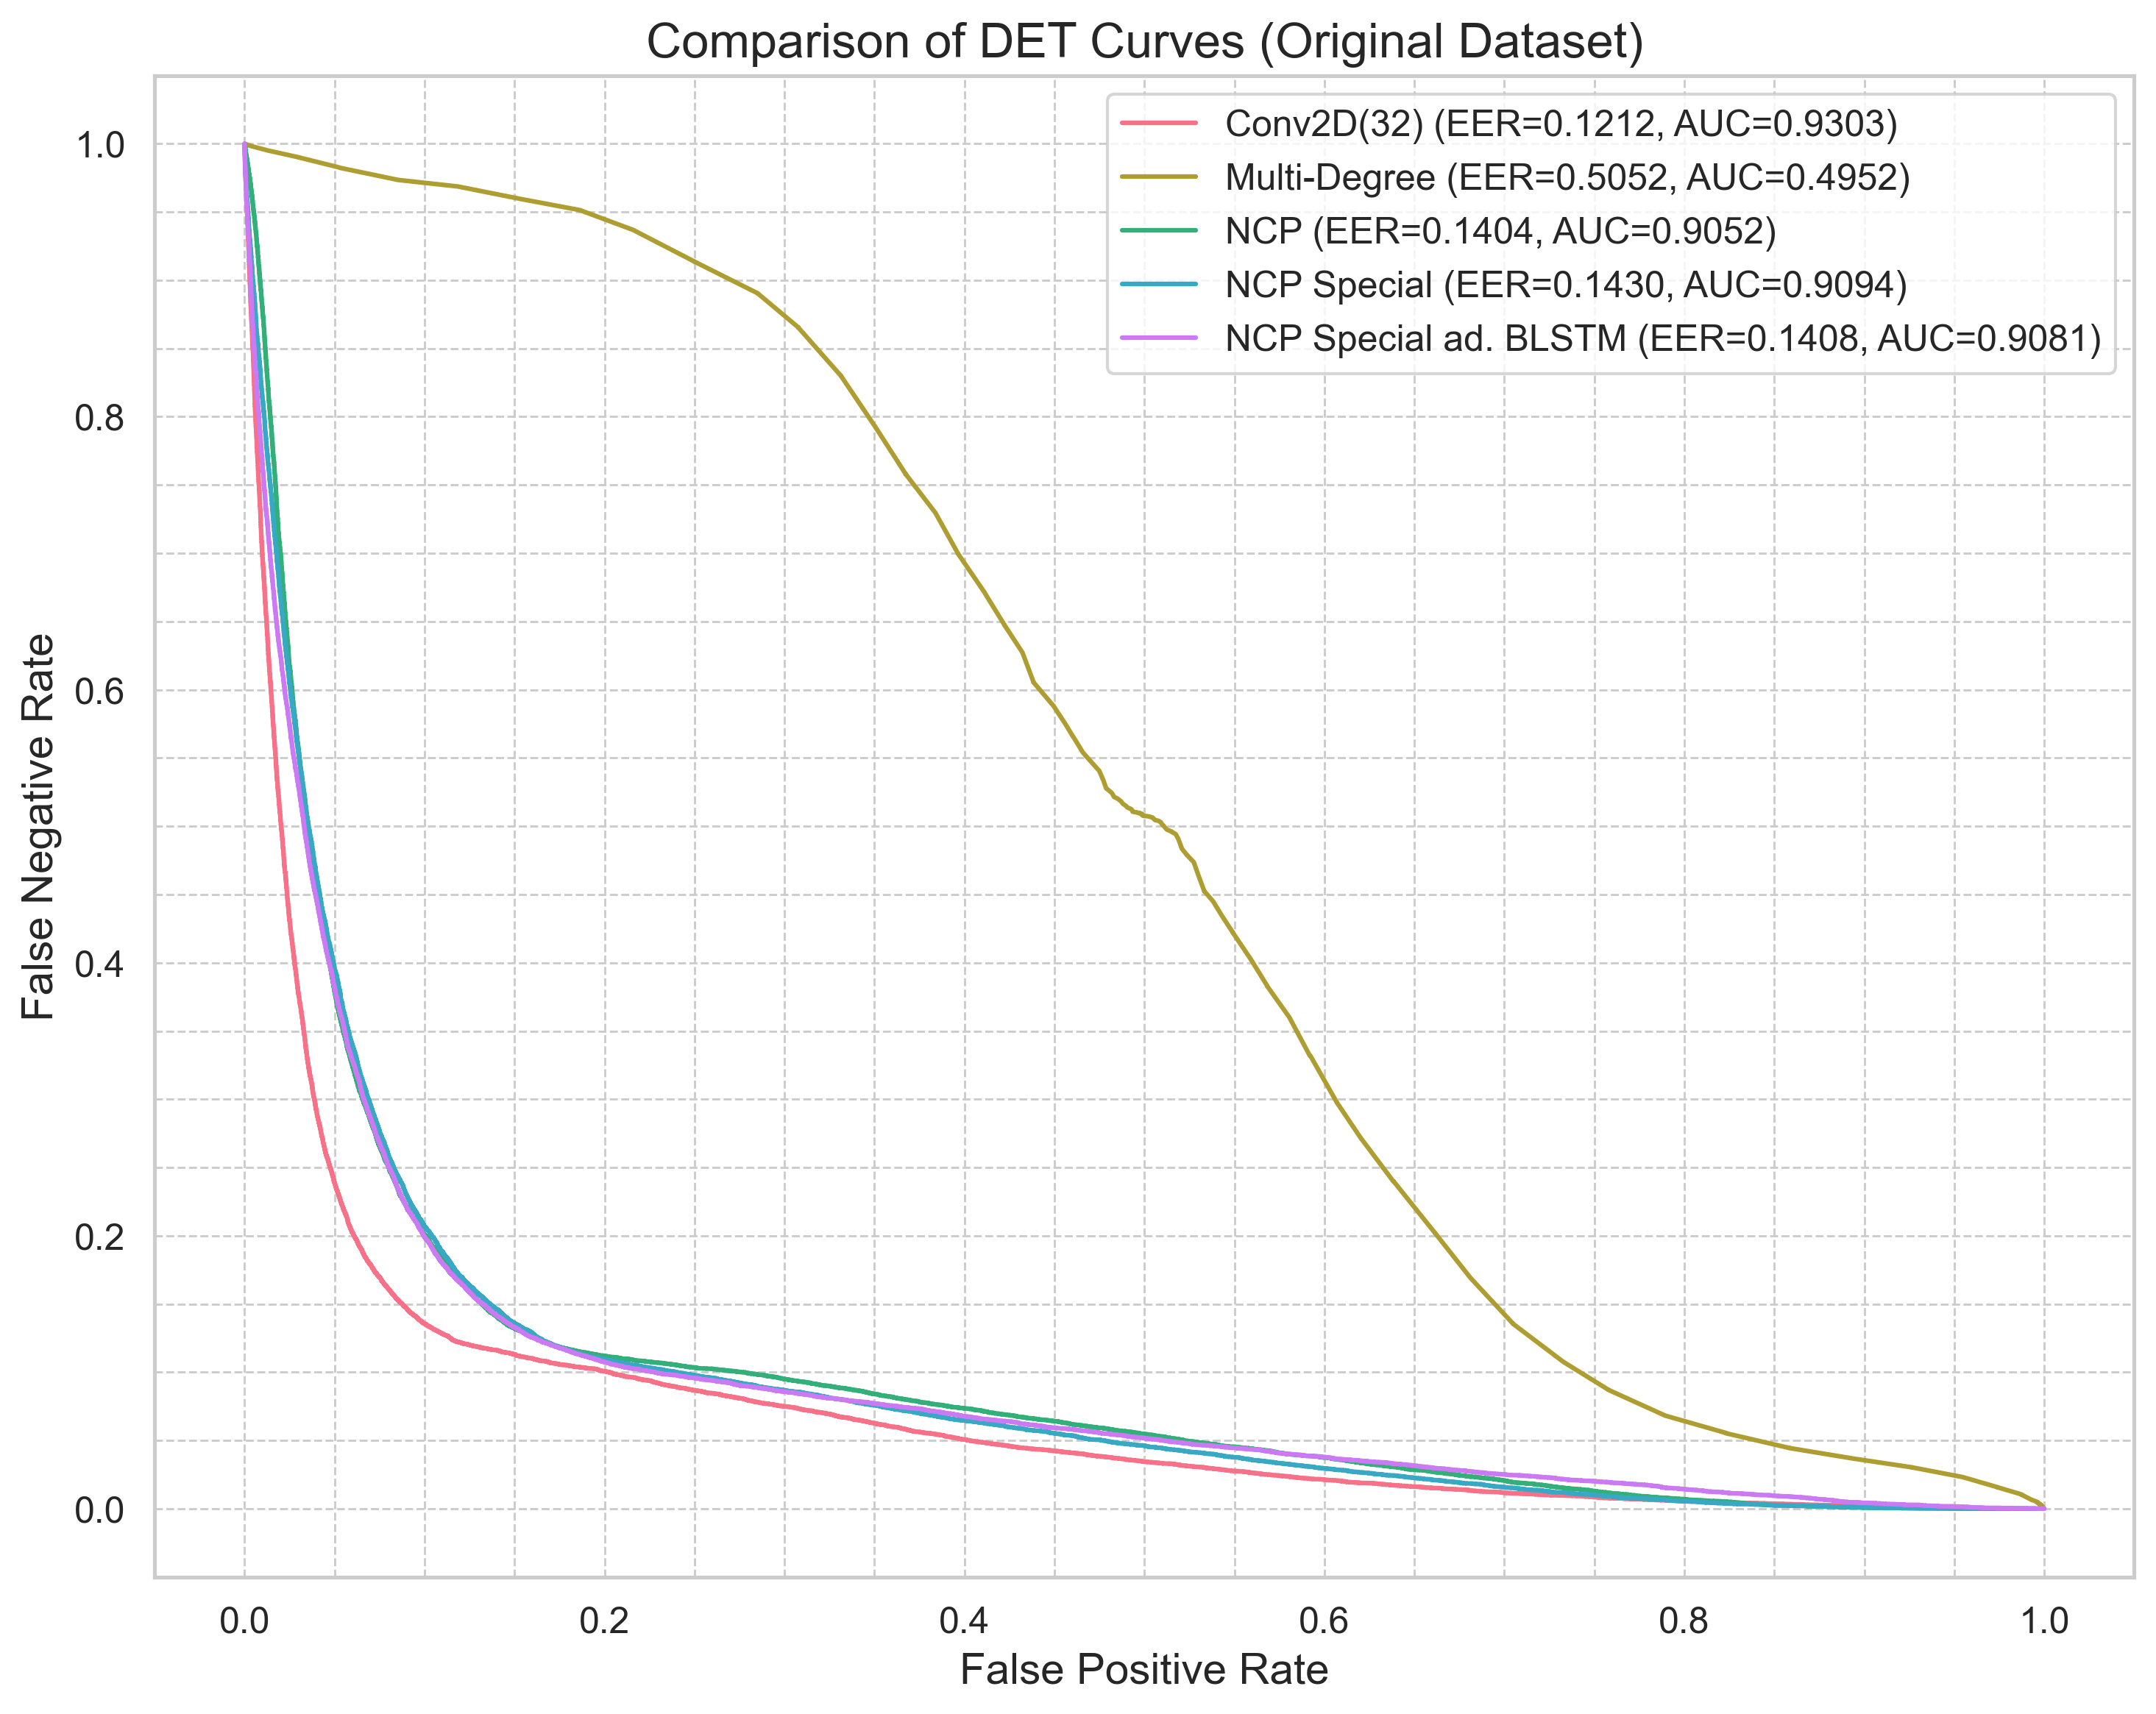

In [17]:
import os
import glob
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

def evaluate_model(score_file_path, keys_file_path):
    #######################################
    # Step 1: Parsing the Scores and Keys #
    #######################################
    def parse_scores(file_path):
        scores = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[0],
                    "score": float(parts[-1])
                }
                scores.append(entry)
        return pd.DataFrame(scores)

    def parse_keys(file_path):
        keys = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[1],
                    "label": parts[-1]
                }
                keys.append(entry)
        return pd.DataFrame(keys)

    # Parse the files
    scores = parse_scores(score_file_path)
    keys = parse_keys(keys_file_path)

    ######################################
    # Step 2: Matching Scores and Labels #
    ######################################
    def match_scores_keys(scores_df, keys_df):
        # Perform the merge operation on the 'file_id' column
        merged_df = pd.merge(scores_df, keys_df, on="file_id", how="inner")
        # Drop rows with NaN values
        merged_df.dropna(inplace=True)
        return merged_df

    # Match scores with keys
    matched_df = match_scores_keys(scores, keys)

    ###############################
    # Step 3: Calculating Metrics  #
    ###############################
    def calculate_metrics(matched_df):
        y_true = matched_df['label'].apply(lambda x: 0 if x == 'spoof' else 1).values
        y_scores = matched_df['score'].values

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
        eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

        auc_roc = roc_auc_score(y_true, y_scores)

        det_fpr, det_fnr, _ = det_curve(y_true, y_scores)

        return eer, auc_roc, det_fpr, det_fnr

    eer, auc_roc, det_fpr, det_fnr = calculate_metrics(matched_df)

    return eer, auc_roc, det_fpr, det_fnr


# Loop through the first seven folders with log_eval_score.txt files and plot the DET curves
def evaluate_and_plot_models(base_dir, keys_file_path, model_names=None):
    # Use glob to find all log_eval_score.txt files in the folder structure
    log_eval_files = glob.glob(os.path.join(base_dir, '**', 'log_eval_score.txt'), recursive=True)

    # Limit to the first seven models
    # log_eval_files = log_eval_files[:7]
    # print(log_eval_files)


    specific_models = [
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\A_ASV_Default_32_Or\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\B_Polynomial_bad_Or\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\C_SinglePoly_ncp_Or\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\D_SinglePoly_32_ncp_Special_Or_logits\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_Only\\E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Or\\baseline_DF\\log_eval_score.txt'
    ]
    log_eval_files = specific_models
    print(log_eval_files)







    # If custom model names are provided, use them, otherwise, generate default names
    if model_names is None or len(model_names) < len(log_eval_files):
        model_names = [f'Model {i+1}' for i in range(len(log_eval_files))]

    # Prepare to plot multiple DET curves on one figure
    plt.figure(figsize=(10, 8), dpi=300)  # Increased DPI for publication quality

    # Set a color cycle for consistency
    colors = sns.color_palette("husl", len(log_eval_files))

    # Loop through each log_eval_score.txt file and evaluate it
    for idx, score_file_path in enumerate(log_eval_files):
        eer, auc_roc, det_fpr, det_fnr = evaluate_model(score_file_path, keys_file_path)
        
        # Plot the DET curve for each model with the provided name
        plt.plot(det_fpr, det_fnr, label=f'{model_names[idx]} (EER={eer:.4f}, AUC={auc_roc:.4f})', color=colors[idx])

    # Set plot labels and title with larger font sizes
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('False Negative Rate', fontsize=14)
    plt.title('Comparison of DET Curves (Original Dataset)', fontsize=16)
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    # Add minor ticks to enhance the readability
    plt.minorticks_on()
    
    # Customize tick parameters
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    
    # Use tight layout to avoid clipping of labels
    plt.tight_layout()

    # Place legend outside the plot for better readability
    #plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=12)
    plt.legend(loc="upper right", fontsize=12)

    # Define output directory and file path
    output_dir = r'C:\Users\User\Desktop\MSc_Latex_Images'
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    output_file_path = os.path.join(output_dir, 'AUC_origin_plot.png')

    # Save the plot as a PNG file
    plt.savefig(output_file_path)


    # Show the plot
    plt.show()


# Example usage:
base_dir = r'C:\Users\User\Desktop\Final_ASV_Results'
keys_file_path = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'

# List of custom model names for the first seven models
model_names = [
    "Conv2D(32)", 
    "Multi-Degree", 
    "NCP", 
    "NCP Special", 
    "NCP Special ad. BLSTM"
]

evaluate_and_plot_models(base_dir, keys_file_path, model_names=model_names)

['C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\A_ASV_Default_32_Au\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\B_Polynomial_64_bad_Au\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\C_SinglePoly_64_ncp_Au\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\D_SinglePoly_32_ncp_Special_Au\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au\\baseline_DF\\log_eval_score.txt']


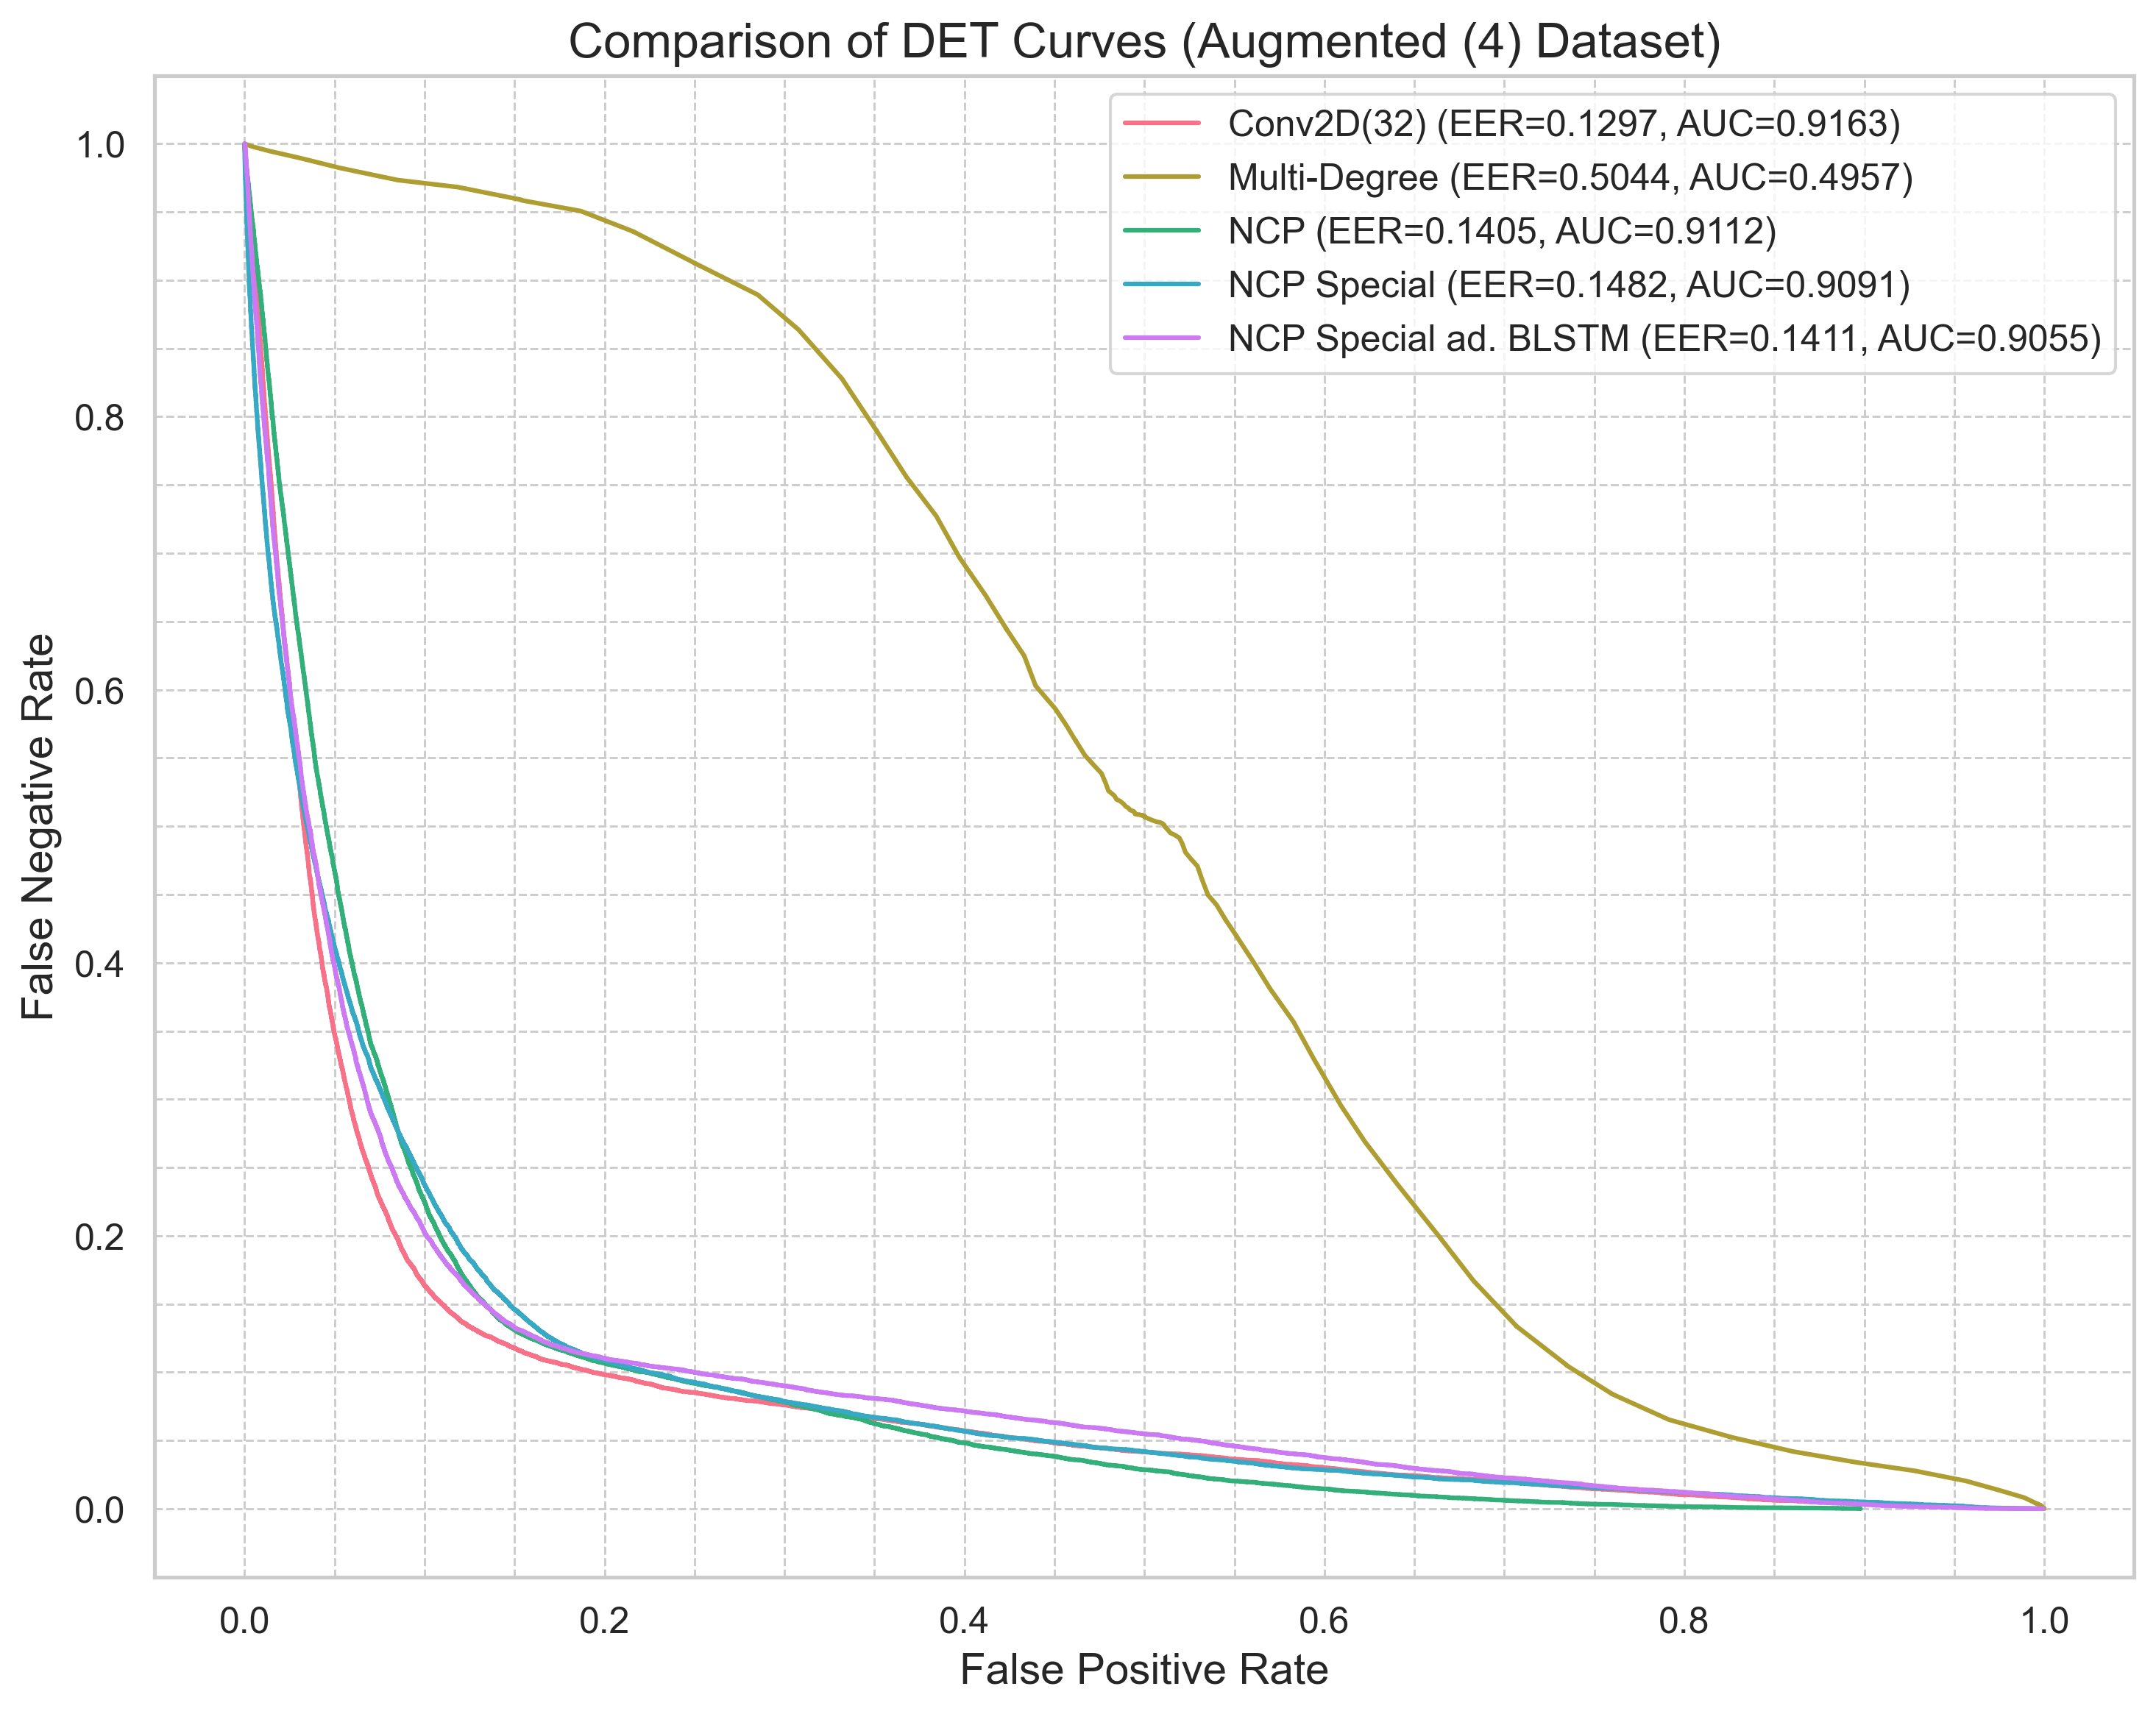

In [20]:
import os
import glob
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

def evaluate_model(score_file_path, keys_file_path):
    #######################################
    # Step 1: Parsing the Scores and Keys #
    #######################################
    def parse_scores(file_path):
        scores = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[0],
                    "score": float(parts[-1])
                }
                scores.append(entry)
        return pd.DataFrame(scores)

    def parse_keys(file_path):
        keys = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[1],
                    "label": parts[-1]
                }
                keys.append(entry)
        return pd.DataFrame(keys)

    # Parse the files
    scores = parse_scores(score_file_path)
    keys = parse_keys(keys_file_path)

    ######################################
    # Step 2: Matching Scores and Labels #
    ######################################
    def match_scores_keys(scores_df, keys_df):
        # Perform the merge operation on the 'file_id' column
        merged_df = pd.merge(scores_df, keys_df, on="file_id", how="inner")
        # Drop rows with NaN values
        merged_df.dropna(inplace=True)
        return merged_df

    # Match scores with keys
    matched_df = match_scores_keys(scores, keys)

    ###############################
    # Step 3: Calculating Metrics  #
    ###############################
    def calculate_metrics(matched_df):
        y_true = matched_df['label'].apply(lambda x: 0 if x == 'spoof' else 1).values
        y_scores = matched_df['score'].values

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
        eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

        auc_roc = roc_auc_score(y_true, y_scores)

        det_fpr, det_fnr, _ = det_curve(y_true, y_scores)

        return eer, auc_roc, det_fpr, det_fnr

    eer, auc_roc, det_fpr, det_fnr = calculate_metrics(matched_df)

    return eer, auc_roc, det_fpr, det_fnr


# Loop through the first seven folders with log_eval_score.txt files and plot the DET curves
def evaluate_and_plot_models(base_dir, keys_file_path, model_names=None):
    # Use glob to find all log_eval_score.txt files in the folder structure
    log_eval_files = glob.glob(os.path.join(base_dir, '**', 'log_eval_score.txt'), recursive=True)

    # Limit to the first seven models
    # log_eval_files = log_eval_files[:7]
    # print(log_eval_files)


    specific_models = [
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\A_ASV_Default_32_Au\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\B_Polynomial_64_bad_Au\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\C_SinglePoly_64_ncp_Au\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\D_SinglePoly_32_ncp_Special_Au\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented\\E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au\\baseline_DF\\log_eval_score.txt'
    ]
    log_eval_files = specific_models
    print(log_eval_files)







    # If custom model names are provided, use them, otherwise, generate default names
    if model_names is None or len(model_names) < len(log_eval_files):
        model_names = [f'Model {i+1}' for i in range(len(log_eval_files))]

    # Prepare to plot multiple DET curves on one figure
    plt.figure(figsize=(10, 8), dpi=300)  # Increased DPI for publication quality

    # Set a color cycle for consistency
    colors = sns.color_palette("husl", len(log_eval_files))

    # Loop through each log_eval_score.txt file and evaluate it
    for idx, score_file_path in enumerate(log_eval_files):
        eer, auc_roc, det_fpr, det_fnr = evaluate_model(score_file_path, keys_file_path)
        
        # Plot the DET curve for each model with the provided name
        plt.plot(det_fpr, det_fnr, label=f'{model_names[idx]} (EER={eer:.4f}, AUC={auc_roc:.4f})', color=colors[idx])

    # Set plot labels and title with larger font sizes
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('False Negative Rate', fontsize=14)
    plt.title('Comparison of DET Curves (Augmented (4) Dataset)', fontsize=16)
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    # Add minor ticks to enhance the readability
    plt.minorticks_on()
    
    # Customize tick parameters
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    
    # Use tight layout to avoid clipping of labels
    plt.tight_layout()

    # Place legend outside the plot for better readability
    #plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=12)
    plt.legend(loc="upper right", fontsize=12)

    # Define output directory and file path
    output_dir = r'C:\Users\User\Desktop\MSc_Latex_Images'
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    output_file_path = os.path.join(output_dir, 'AUC_origin_plot.png')

    # Save the plot as a PNG file
    plt.savefig(output_file_path)


    # Show the plot
    plt.show()


# Example usage:
base_dir = r'C:\Users\User\Desktop\Final_ASV_Results'
keys_file_path = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'

# List of custom model names for the first seven models
model_names = [
    "Conv2D(32)", 
    "Multi-Degree", 
    "NCP", 
    "NCP Special", 
    "NCP Special ad. BLSTM"
]

evaluate_and_plot_models(base_dir, keys_file_path, model_names=model_names)

['C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\A_ASV_Default_32_Augment_5_logits\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\B_ASV_BadPolynom_32_Augment_5\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\C_ASV_NCP_32_Augment_5\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\D_ASV_Special_32_Augment_5_logits\\baseline_DF\\log_eval_score.txt', 'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\E_ASV_Special_ThreeBLSTM_32_Augment_5\\baseline_DF\\log_eval_score.txt']


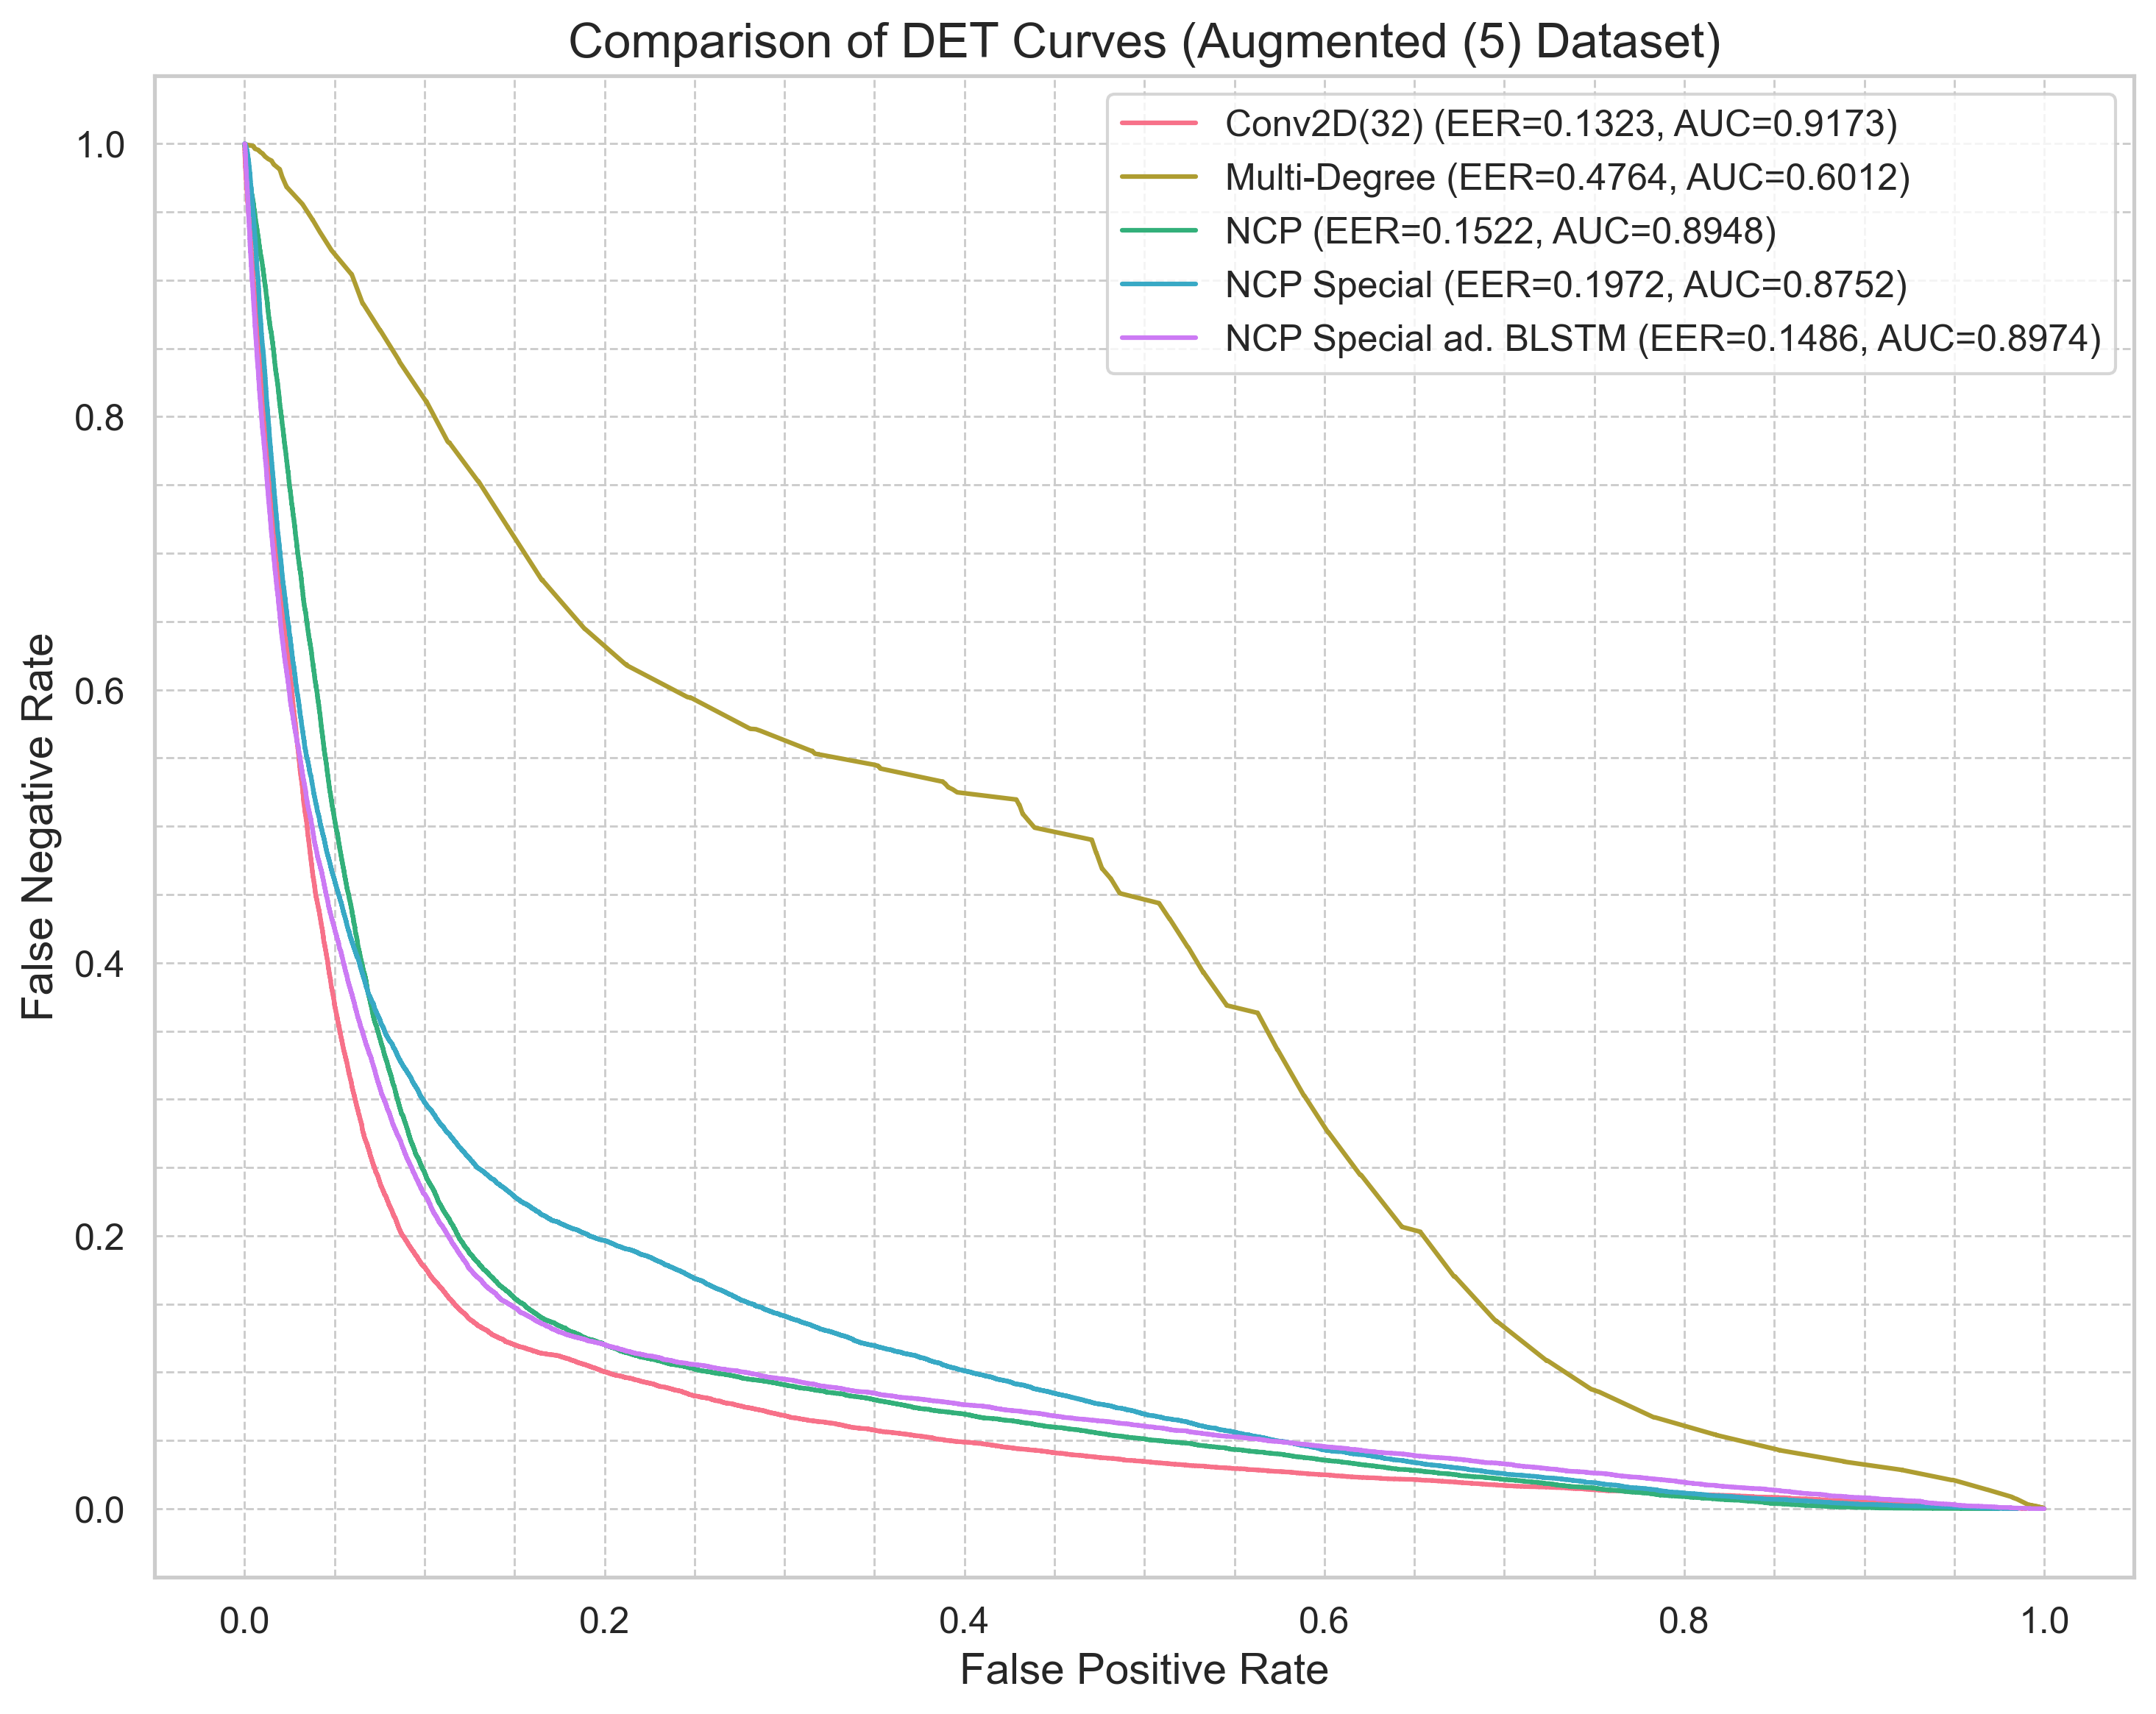

In [29]:
import os
import glob
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

def evaluate_model(score_file_path, keys_file_path):
    #######################################
    # Step 1: Parsing the Scores and Keys #
    #######################################
    def parse_scores(file_path):
        scores = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[0],
                    "score": float(parts[-1])
                }
                scores.append(entry)
        return pd.DataFrame(scores)

    def parse_keys(file_path):
        keys = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                entry = {
                    "file_id": parts[1],
                    "label": parts[-1]
                }
                keys.append(entry)
        return pd.DataFrame(keys)

    # Parse the files
    scores = parse_scores(score_file_path)
    keys = parse_keys(keys_file_path)

    ######################################
    # Step 2: Matching Scores and Labels #
    ######################################
    def match_scores_keys(scores_df, keys_df):
        # Perform the merge operation on the 'file_id' column
        merged_df = pd.merge(scores_df, keys_df, on="file_id", how="inner")
        # Drop rows with NaN values
        merged_df.dropna(inplace=True)
        return merged_df

    # Match scores with keys
    matched_df = match_scores_keys(scores, keys)

    ###############################
    # Step 3: Calculating Metrics  #
    ###############################
    def calculate_metrics(matched_df):
        y_true = matched_df['label'].apply(lambda x: 0 if x == 'spoof' else 1).values
        y_scores = matched_df['score'].values

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
        eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

        auc_roc = roc_auc_score(y_true, y_scores)

        det_fpr, det_fnr, _ = det_curve(y_true, y_scores)

        return eer, auc_roc, det_fpr, det_fnr

    eer, auc_roc, det_fpr, det_fnr = calculate_metrics(matched_df)

    return eer, auc_roc, det_fpr, det_fnr


# Loop through the first seven folders with log_eval_score.txt files and plot the DET curves
def evaluate_and_plot_models(base_dir, keys_file_path, model_names=None):
    # Use glob to find all log_eval_score.txt files in the folder structure
    log_eval_files = glob.glob(os.path.join(base_dir, '**', 'log_eval_score.txt'), recursive=True)

    # Limit to the first seven models
    # log_eval_files = log_eval_files[:7]
    # print(log_eval_files)


    specific_models = [
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\A_ASV_Default_32_Augment_5_logits\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\B_ASV_BadPolynom_32_Augment_5\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\C_ASV_NCP_32_Augment_5\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\D_ASV_Special_32_Augment_5_logits\\baseline_DF\\log_eval_score.txt',
    'C:\\Users\\User\\Desktop\\Final_ASV_Results\\Original_and_Augmented_Raw_5\\E_ASV_Special_ThreeBLSTM_32_Augment_5\\baseline_DF\\log_eval_score.txt'
    ]
    log_eval_files = specific_models
    print(log_eval_files)







    # If custom model names are provided, use them, otherwise, generate default names
    if model_names is None or len(model_names) < len(log_eval_files):
        model_names = [f'Model {i+1}' for i in range(len(log_eval_files))]

    # Prepare to plot multiple DET curves on one figure
    plt.figure(figsize=(10, 8), dpi=300)  # Increased DPI for publication quality

    # Set a color cycle for consistency
    colors = sns.color_palette("husl", len(log_eval_files))

    # Loop through each log_eval_score.txt file and evaluate it
    for idx, score_file_path in enumerate(log_eval_files):
        eer, auc_roc, det_fpr, det_fnr = evaluate_model(score_file_path, keys_file_path)
        
        # Plot the DET curve for each model with the provided name
        plt.plot(det_fpr, det_fnr, label=f'{model_names[idx]} (EER={eer:.4f}, AUC={auc_roc:.4f})', color=colors[idx])

    # Set plot labels and title with larger font sizes
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('False Negative Rate', fontsize=14)
    plt.title('Comparison of DET Curves (Augmented (5) Dataset)', fontsize=16)
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    # Add minor ticks to enhance the readability
    plt.minorticks_on()
    
    # Customize tick parameters
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    
    # Use tight layout to avoid clipping of labels
    plt.tight_layout()

    # Place legend outside the plot for better readability
    #plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=12)
    plt.legend(loc="upper right", fontsize=12)

    # Define output directory and file path
    output_dir = r'C:\Users\User\Desktop\MSc_Latex_Images'
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    output_file_path = os.path.join(output_dir, 'AUC_origin_plot.png')

    # Save the plot as a PNG file
    plt.savefig(output_file_path)


    # Show the plot
    plt.show()


# Example usage:
base_dir = r'C:\Users\User\Desktop\Final_ASV_Results'
keys_file_path = r'C:\Users\User\Desktop\Processed_ASV_Data\Eval_CM_2021_Metadata\correct_eval_metadata.txt'

# List of custom model names for the first seven models
model_names = [
    "Conv2D(32)", 
    "Multi-Degree", 
    "NCP", 
    "NCP Special", 
    "NCP Special ad. BLSTM"
]

evaluate_and_plot_models(base_dir, keys_file_path, model_names=model_names)

### Get the data from the txt file (in list format)

In [ ]:
import re
import matplotlib.pyplot as plt



# File path
file_path = r"C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\A_ASV_Default_32\baseline_DF\log_train.txt"

# Read the file
with open(file_path, 'r') as file:
    log_data = file.read()

# Define the pattern to match the table section (from 'Epoch' to the end of the table)
table_pattern = r"-{5,}\s*\n\s*Epoch\s*\|\s*Duration\(s\)\s*\|\s*Train loss\s*\|\s*Dev loss\s*\|\s*Best\s*\n-{5,}\n(.*?)\n-{5,}"

# Use regular expression to find the table
match = re.search(table_pattern, log_data, re.DOTALL)

if match:
    # Extract the table rows
    table = match.group(1).strip()
    
    # Split the rows into individual rows
    rows = table.split('\n')
    
    # Prepare lists for each column
    epochs = []
    durations = []
    train_losses = []
    dev_losses = []
    bests = []

    # Iterate through each row and extract column values (skip the header)
    for row in rows:
        # Use regex to split by '|' and then strip leading/trailing spaces from each column
        columns = [col.strip() for col in re.split(r'\s*\|\s*', row) if col]
        
        if len(columns) == 5:  # Ensure we have 5 columns
            epochs.append(columns[0])
            durations.append(float(columns[1]))
            train_losses.append(float(columns[2]))
            dev_losses.append(float(columns[3]))
            bests.append(columns[4])
    
    # Print the extracted values for each column
    print("\nEpochs:", epochs)
    print("Durations:", durations)
    print("Train Losses:", train_losses)
    print("Dev Losses:", dev_losses)
    print("Best:", bests)

    print( "Mean training time per epoch:", sum(durations)/len(durations) )
else:
    print("Table not found")


### Find the mean time of epoch per model

In [2]:
import os
import re
font = {'size': 11} # In LaTeX use [width=1\linewidth] for the graph (Single Graphs ONLY)
plt.rc('font', **font)
def extract_mean_time(log_data):
    """
    Extract mean time per epoch from log data using regex pattern.
    """
    # Define the pattern to match the table section (from 'Epoch' to the end of the table)
    table_pattern = r"-{5,}\s*\n\s*Epoch\s*\|\s*Duration\(s\)\s*\|\s*Train loss\s*\|\s*Dev loss\s*\|\s*Best\s*\n-{5,}\n(.*?)\n-{5,}"
    
    # Use regular expression to find the table
    match = re.search(table_pattern, log_data, re.DOTALL)
    
    if match:
        # Extract the table rows
        table = match.group(1).strip()
        
        # Split the rows into individual rows
        rows = table.split('\n')
        
        # Prepare lists for each column
        durations = []

        # Iterate through each row and extract column values (skip the header)
        for row in rows:
            # Use regex to split by '|' and then strip leading/trailing spaces from each column
            columns = [col.strip() for col in re.split(r'\s*\|\s*', row) if col]
            
            if len(columns) == 5:  # Ensure we have 5 columns
                durations.append(float(columns[1]))  # Get duration column
        
        if durations:
            return sum(durations) / len(durations)  # Return mean duration
    return None  # Return None if no valid table found


def find_log_files_and_calculate_mean(root_dir):
    """
    Traverse through all folders starting from root_dir, 
    find log_train.txt files, and calculate the mean training time.
    """
    results = {}

    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file == "log_train.txt":
                file_path = os.path.join(subdir, file)
                
                with open(file_path, 'r') as f:
                    log_data = f.read()
                
                mean_time = extract_mean_time(log_data)
                
                if mean_time is not None:
                    results[file_path] = mean_time

    return results


# Specify the root directory containing subfolders with log_train.txt files
root_directory = r"C:\Users\User\Desktop\Final_ASV_Results"

# Find the log files and calculate mean training times
mean_times = find_log_files_and_calculate_mean(root_directory)

# Print the results
for log_file, mean_time in mean_times.items():
    print(f"Mean time for {log_file}: {mean_time:.2f} seconds")


Mean time for C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\A_ASV_Default_32_Au\baseline_DF\log_train.txt: 103.05 seconds
Mean time for C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\B_Polynomial_64_bad_Au\baseline_DF\log_train.txt: 368.94 seconds
Mean time for C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\C_SinglePoly_64_ncp_Au\baseline_DF\log_train.txt: 225.89 seconds
Mean time for C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\D_SinglePoly_32_ncp_Special_Au\baseline_DF\log_train.txt: 275.72 seconds
Mean time for C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au\baseline_DF\log_train.txt: 276.15 seconds
Mean time for C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\F_ASV_Default_64_Au\baseline_DF\log_train.txt: 89.24 seconds
Mean time for C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\G_SinglePoly_32_ncp_Special_four_layers_

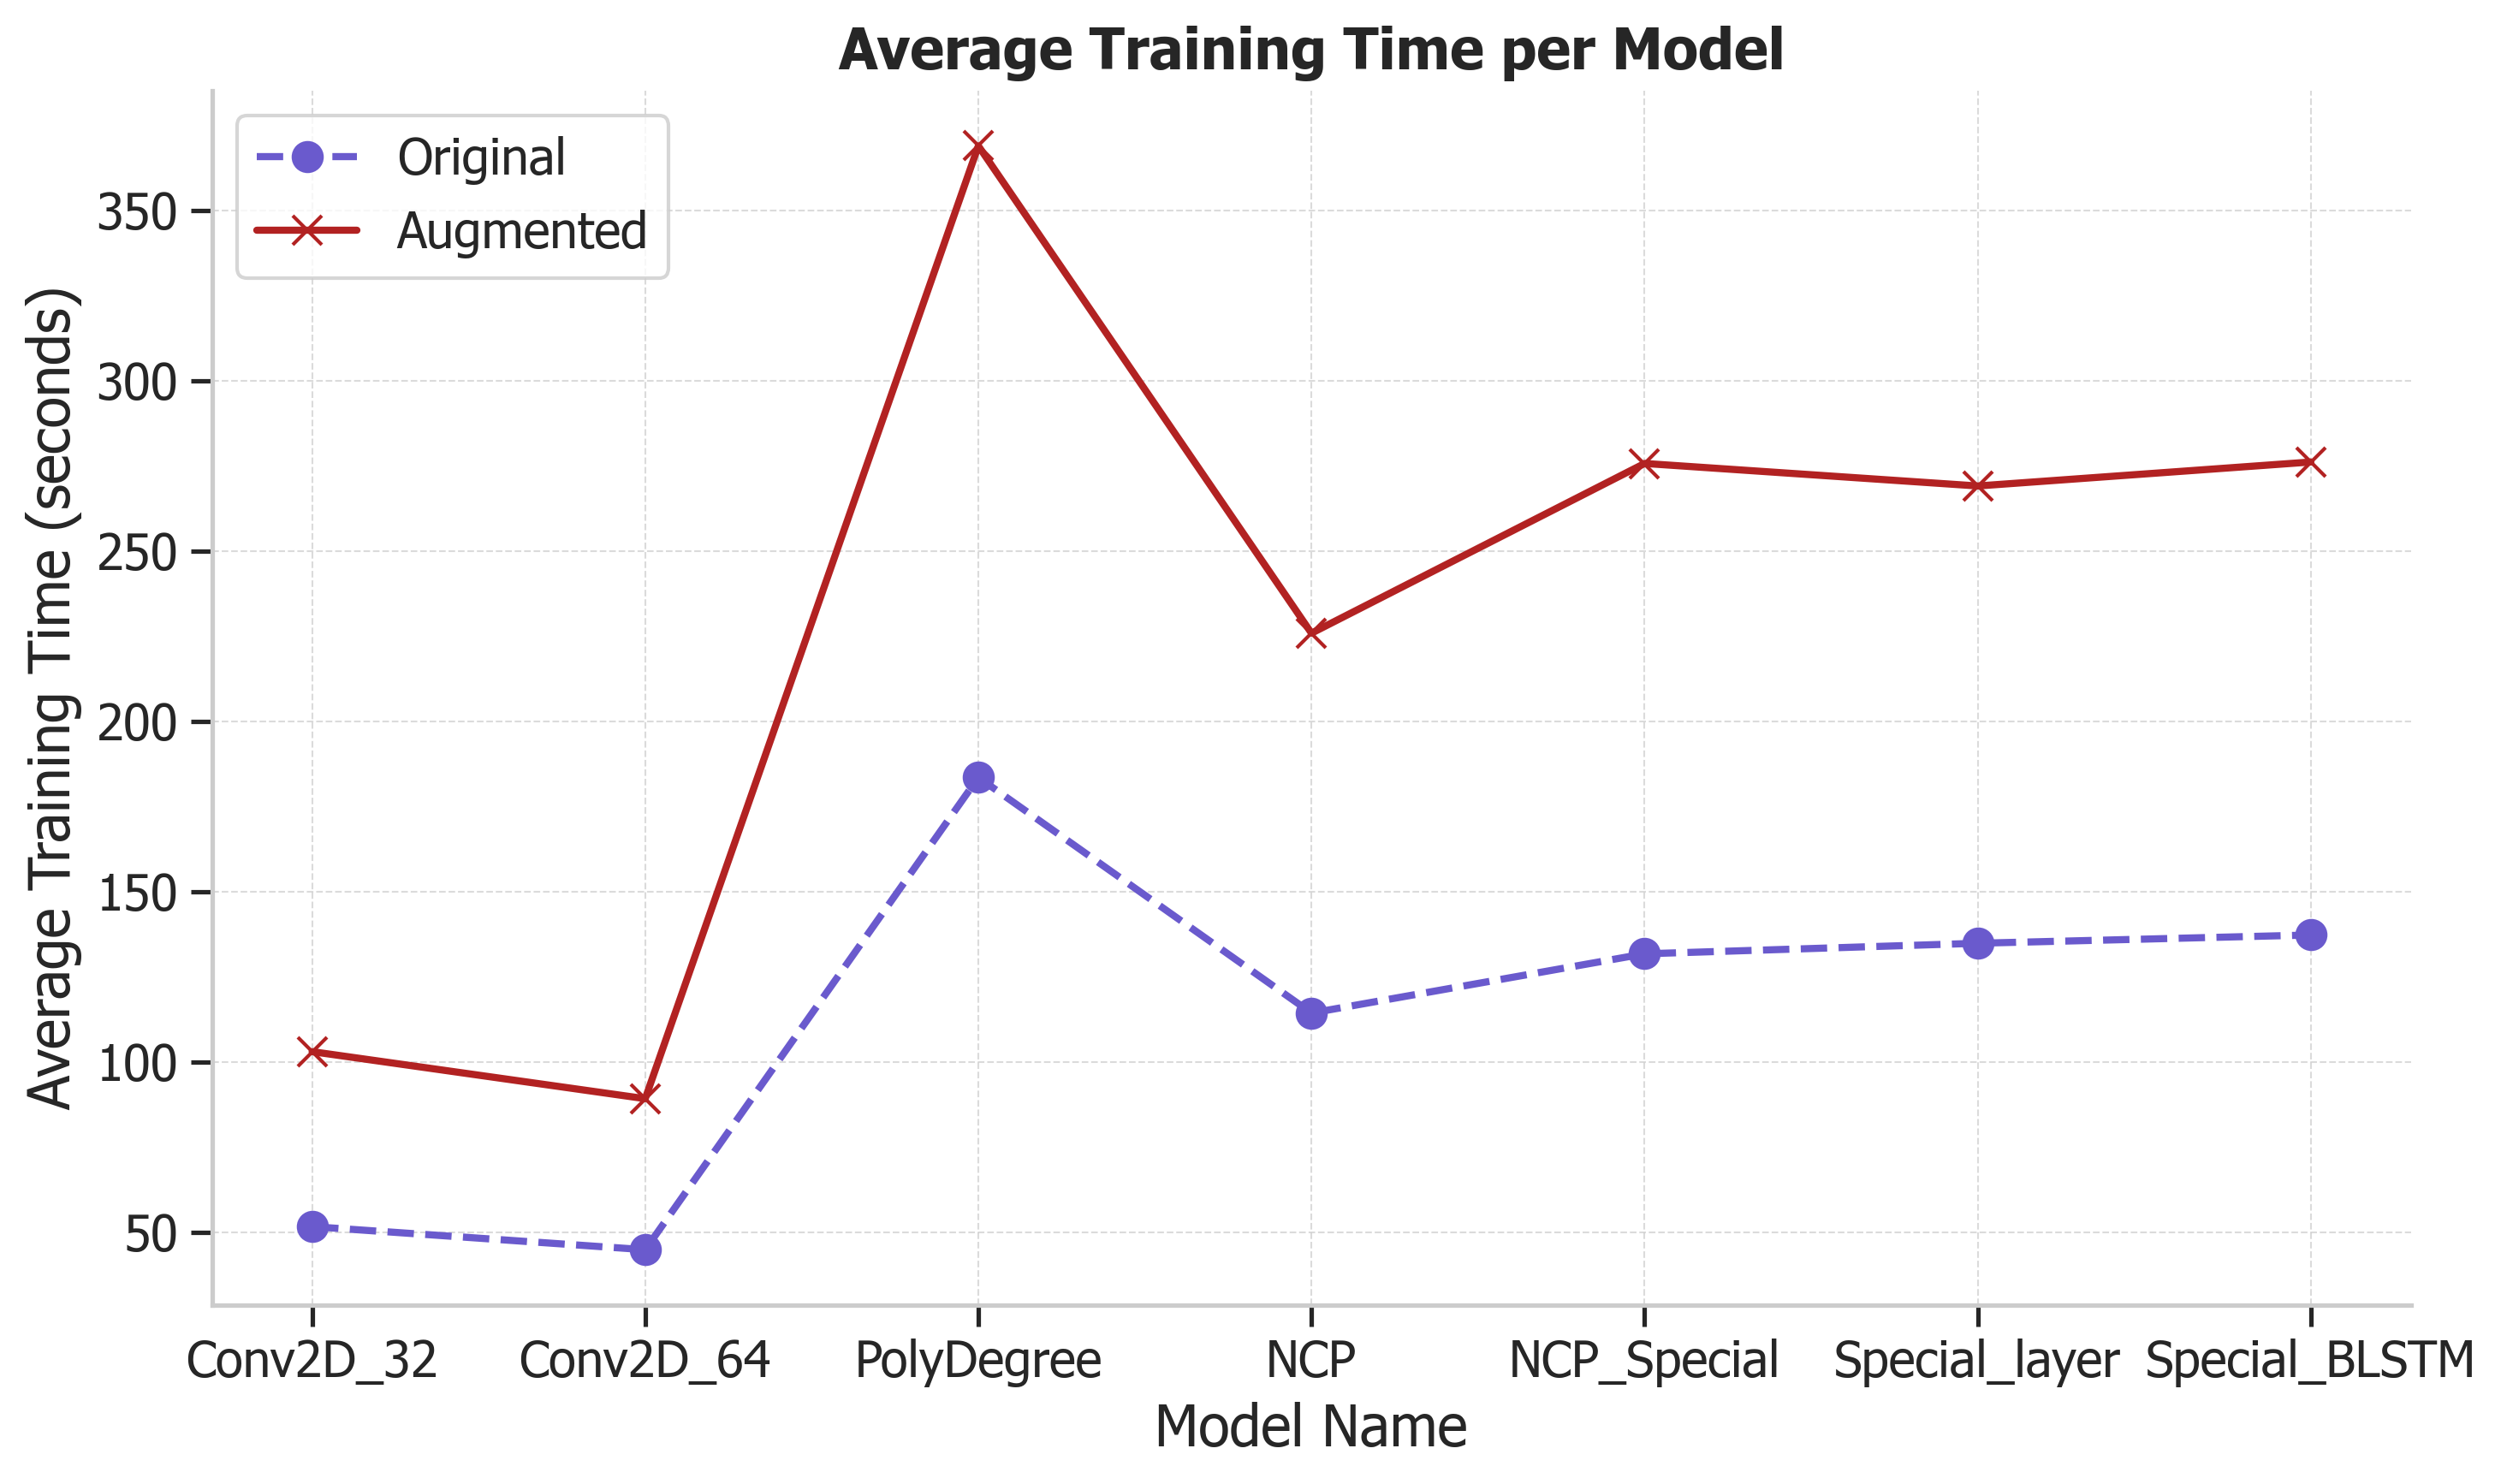

Plot saved to C:\Users\User\Desktop\MSc_Latex_Images\mean_training_time_plot.png


In [70]:
import matplotlib.pyplot as plt
import os

# Set font and sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Tahoma")  # Use Roboto font
plt.rc("font", weight="normal")  # Normal weight font
plt.rc("font", size=SIZE_DEFAULT)  # Default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # Axes title fontsize
plt.rc("axes", labelsize=SIZE_LARGE)  # X and Y labels fontsize
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # Tick label fontsize
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # Tick label fontsize

# Data
Model_names = ["Conv2D_32", "Conv2D_64", "PolyDegree", "NCP", "NCP_Special", "Special_layer", "Special_BLSTM"]
Mean_time_original = [51.69, 44.90, 183.55, 114.39, 131.77, 134.87, 137.30] 
Mean_time_augment = [103.05, 89.24, 368.94, 225.89, 275.72, 269.11, 276.15]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Define a color palette
colors = ["slateblue", "firebrick"]

# Plot Original results
ax.plot(Model_names, Mean_time_original, label="Original", color=colors[0], marker='o', linestyle='--', linewidth=2, markersize=8)

# Plot Augmented results
ax.plot(Model_names, Mean_time_augment, label="Augmented", color=colors[1], marker='x', linestyle='-', linewidth=2, markersize=8)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the axes
ax.set_xlabel('Model Name', fontsize=SIZE_LARGE)
ax.set_ylabel('Average Training Time (seconds)', fontsize=SIZE_LARGE)
ax.set_title('Average Training Time per Model', fontsize=SIZE_LARGE, fontweight='bold')

# Add legend
ax.legend(loc="upper left", fontsize=SIZE_DEFAULT)

# Hide spines and show ticks only on the bottom and left
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Set tight layout
plt.tight_layout()

# Define output directory and file path
output_dir = r'C:\Users\User\Desktop\MSc_Latex_Images'
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
output_file_path = os.path.join(output_dir, 'mean_training_time_plot.png')

# Save the plot as a PNG file
plt.savefig(output_file_path)

# Display the plot
plt.show()

print(f"Plot saved to {output_file_path}")


### Create the Train/Dev loss diagram


Epochs: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Durations: [101.6, 103.1, 103.2, 103.2, 103.5, 103.2, 103.2, 103.3, 102.8, 102.5, 103.0, 102.8, 103.3, 102.9, 103.1, 103.1, 103.2, 103.1, 103.4, 103.5]
Train Losses: [0.2558, 0.0827, 0.045, 0.035, 0.0307, 0.0278, 0.0229, 0.0206, 0.0148, 0.0206, 0.0066, 0.0059, 0.0043, 0.0029, 0.0025, 0.0041, 0.0054, 0.0043, 0.0026, 0.0026]
Dev Losses: [0.2269, 0.0415, 0.0326, 0.0359, 0.0308, 0.0477, 0.0261, 0.0281, 0.0405, 0.0241, 0.0359, 0.0293, 0.0203, 0.0232, 0.0258, 0.041, 0.0191, 0.0734, 0.0329, 0.0385]
Best: ['yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'no', 'yes LR -> 1.50e-03', 'no LR -> 1.50e-03', 'no LR -> 1.50e-03', 'yes LR -> 1.50e-03', 'no LR -> 1.50e-03', 'no LR -> 1.50e-03', 'no LR -> 1.50e-03', 'yes LR -> 1.50e-03', 'no LR -> 1.50e-03', 'no LR -> 1.50e-03', 'no LR -> 7.50e-04']


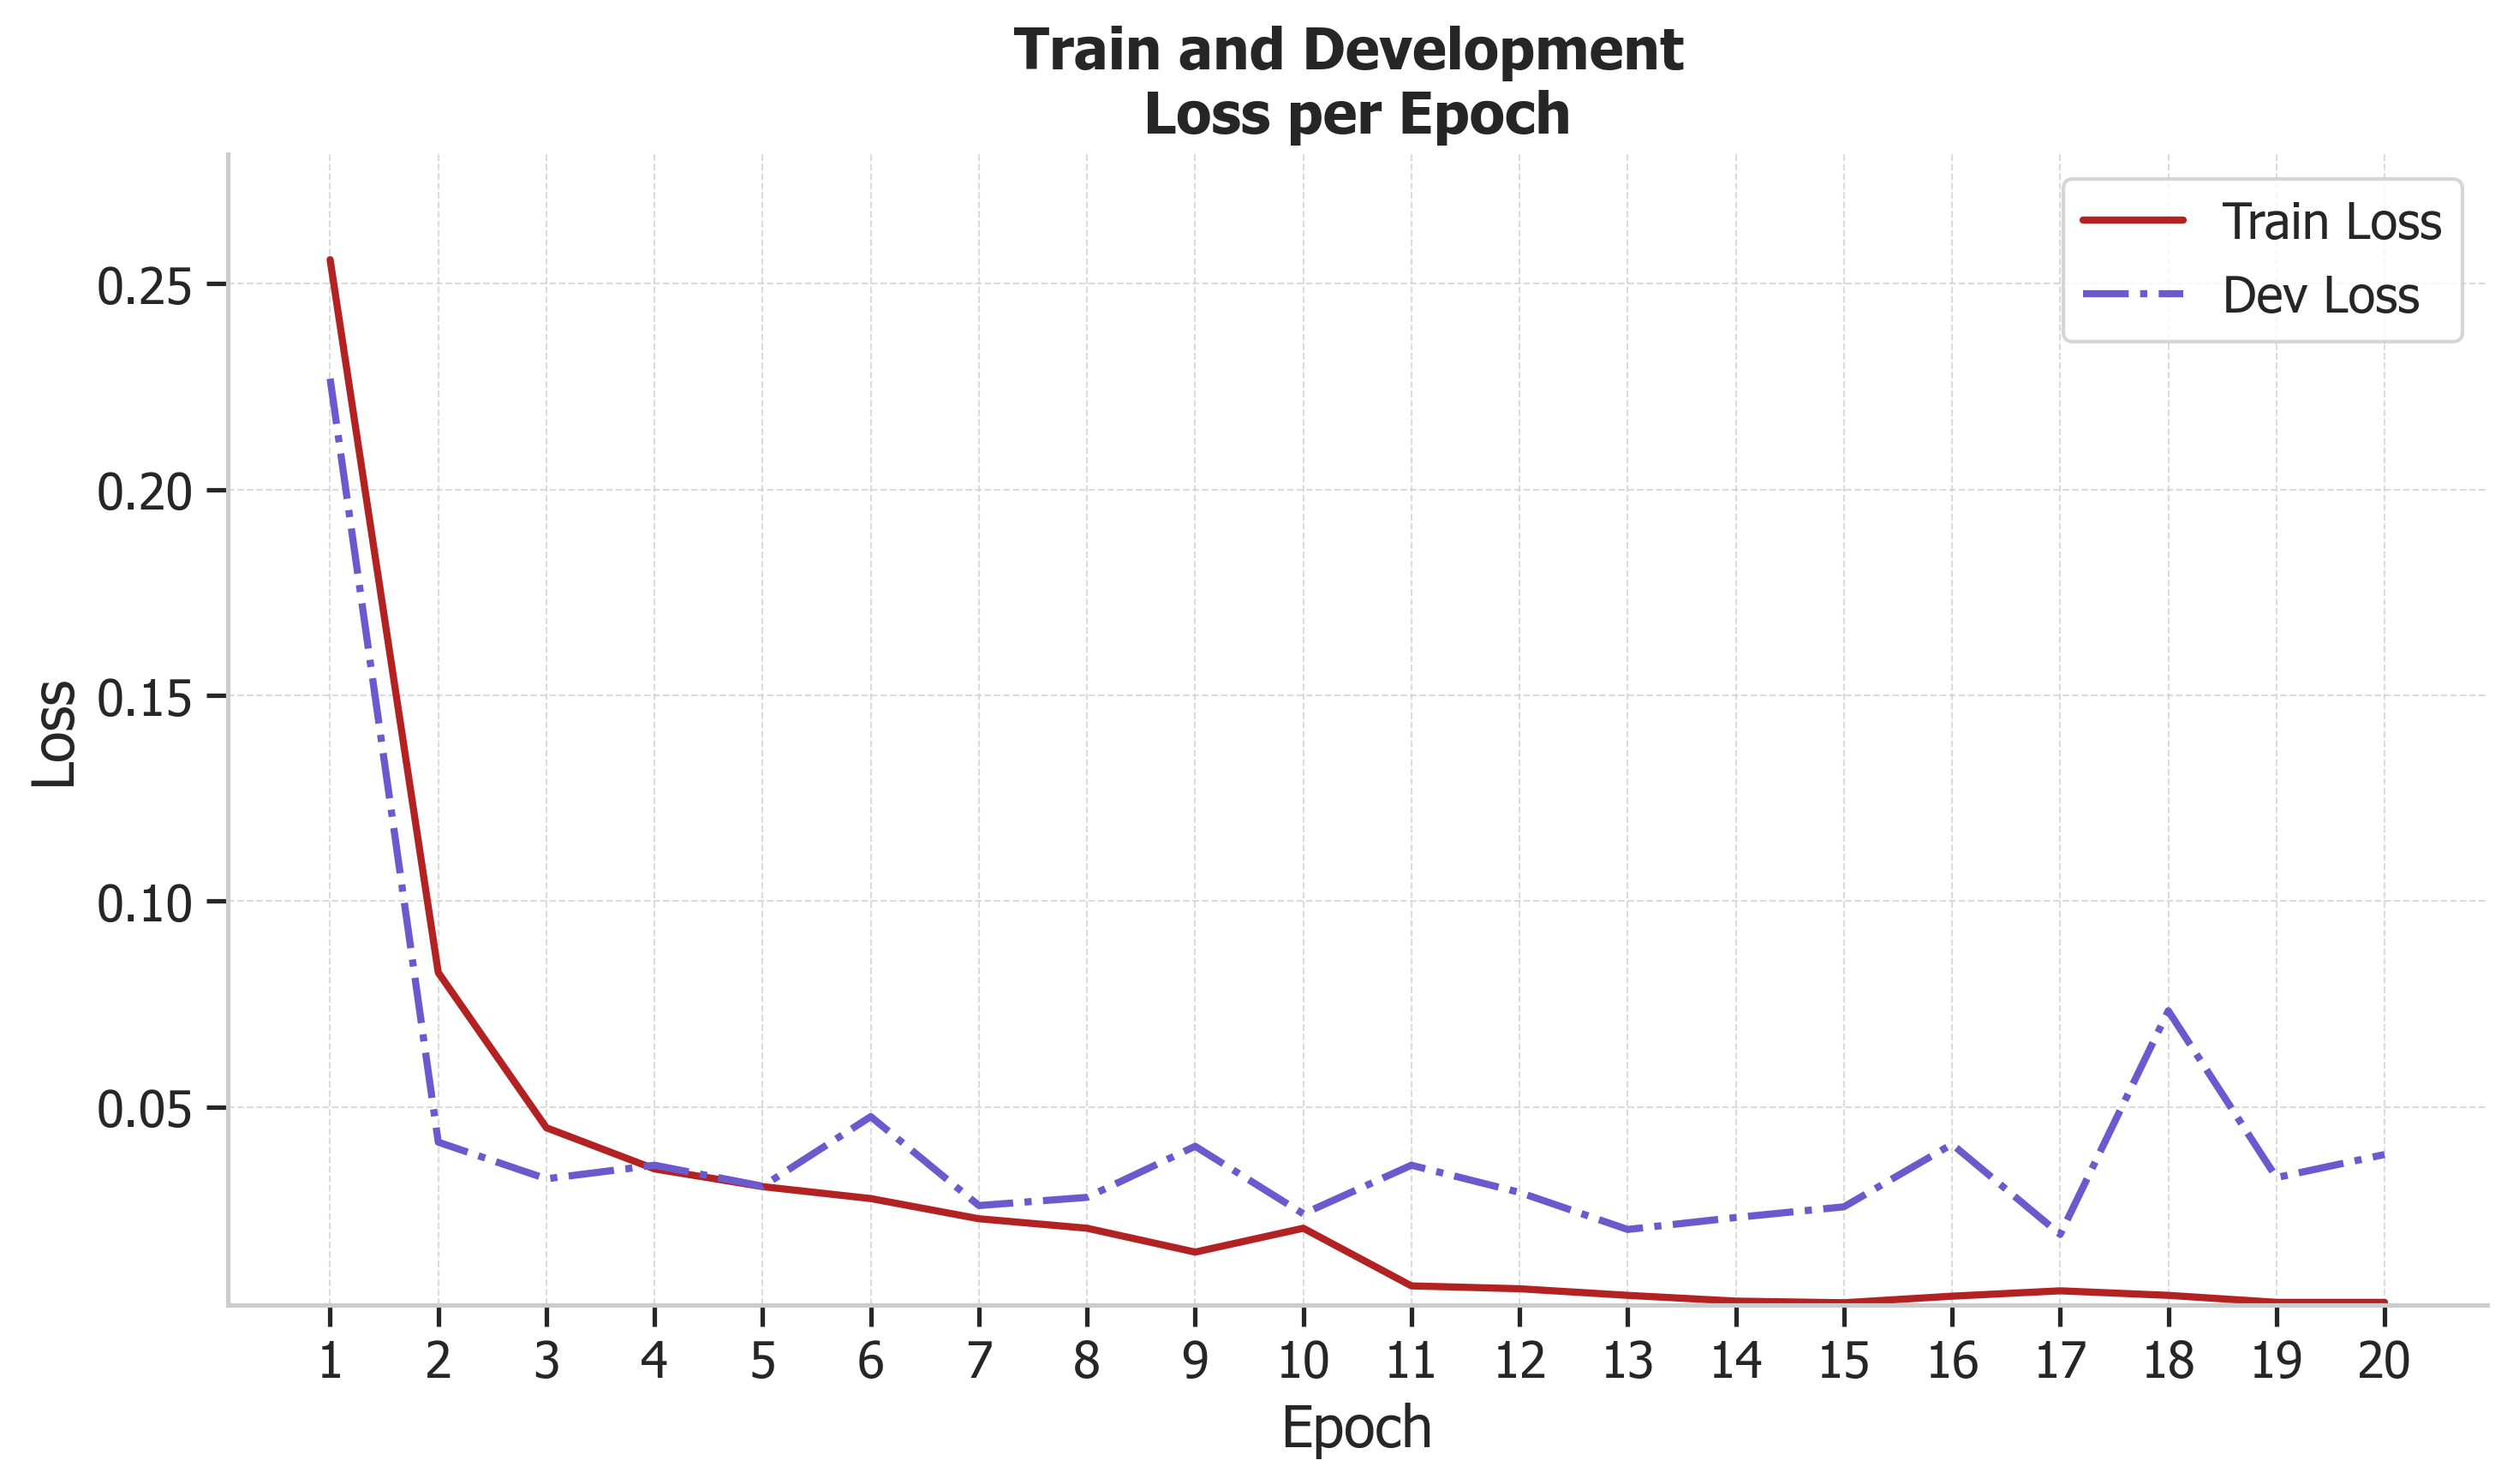

Plot saved to C:\Users\User\Desktop\MSc_Latex_Images\train_dev_loss_plot.png


In [67]:
import re
import matplotlib.pyplot as plt
import os

# Set font and sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Tahoma")  # Use Roboto font
plt.rc("font", weight="normal")  # Normal weight font
plt.rc("font", size=SIZE_DEFAULT)  # Default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # Axes title fontsize
plt.rc("axes", labelsize=SIZE_LARGE)  # X and Y labels fontsize
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # Tick label fontsize
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # Tick label fontsize

# File path
file_path = r"C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\A_ASV_Default_32_Au\baseline_DF\log_train.txt"

# Read the file
with open(file_path, 'r') as file:
    log_data = file.read()

# Define the pattern to match the table section (from 'Epoch' to the end of the table)
table_pattern = r"-{5,}\s*\n\s*Epoch\s*\|\s*Duration\(s\)\s*\|\s*Train loss\s*\|\s*Dev loss\s*\|\s*Best\s*\n-{5,}\n(.*?)\n-{5,}"

# Use regular expression to find the table
match = re.search(table_pattern, log_data, re.DOTALL)

if match:
    # Extract the table rows
    table = match.group(1).strip()
    
    # Split the rows into individual rows
    rows = table.split('\n')
    
    # Prepare lists for each column
    epochs = []
    durations = []
    train_losses = []
    dev_losses = []
    bests = []

    # Iterate through each row and extract column values (skip the header)
    for row in rows:
        # Use regex to split by '|' and then strip leading/trailing spaces from each column
        columns = [col.strip() for col in re.split(r'\s*\|\s*', row) if col]
        
        if len(columns) == 5:  # Ensure we have 5 columns
            epochs.append(str(int(columns[0])+1))
            durations.append(float(columns[1]))
            train_losses.append(float(columns[2]))
            dev_losses.append(float(columns[3]))
            bests.append(columns[4])
    
    # Print the extracted values for each column
    print("\nEpochs:", epochs)
    print("Durations:", durations)
    print("Train Losses:", train_losses)
    print("Dev Losses:", dev_losses)
    print("Best:", bests)

    # Define the common y-axis limits
    y_min = min(min(train_losses), min(dev_losses))
    y_max = max(max(train_losses), max(dev_losses))

    # Plotting the data
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    # Plot Train and Dev Loss
    ax.plot(epochs, train_losses, label='Train Loss', color="firebrick", linewidth=2)  # Red color
    ax.plot(epochs, dev_losses, label='Dev Loss', color="slateblue", linestyle="dashdot", linewidth=2)  # Dark color

    # Customize the axes
    ax.set_xlabel('Epoch', fontsize=SIZE_LARGE)
    ax.set_ylabel('Loss', fontsize=SIZE_LARGE)
    ax.set_title('Train and Development \nLoss per Epoch', fontsize=SIZE_LARGE, fontweight='bold')
    
    # Add legend
    ax.legend(fontsize=SIZE_DEFAULT)

    # Grid and limits
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_ylim([y_min - 0.2 * y_min, y_max + 0.1 * y_max])

    # Hide spines and show ticks only on the bottom and left
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")

    # Set tight layout
    plt.tight_layout()

    # Define output directory and file path
    output_dir = r'C:\Users\User\Desktop\MSc_Latex_Images'
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    output_file_path = os.path.join(output_dir, 'train_dev_loss_plot.png')

    # Save the plot as a PNG file
    plt.savefig(output_file_path)

    # Display the plot
    plt.show()

    print(f"Plot saved to {output_file_path}")
else:
    print("Table not found")

In [ ]:
# Create the diagrams but does not save them in the same folder
'''
font = {'size': 11} # In LaTeX use [width=1\linewidth] for the graph (Single Graphs ONLY)
plt.rc('font', **font)

import os
import glob
import re
import matplotlib.pyplot as plt

# Function to extract and plot data from each log file
def plot_loss_from_log(file_path):
    with open(file_path, 'r') as file:
        log_data = file.read()

    # Define the pattern to match the table section
    table_pattern = r"-{5,}\s*\n\s*Epoch\s*\|\s*Duration\(s\)\s*\|\s*Train loss\s*\|\s*Dev loss\s*\|\s*Best\s*\n-{5,}\n(.*?)\n-{5,}"

    # Use regular expression to find the table
    match = re.search(table_pattern, log_data, re.DOTALL)

    if match:
        # Extract the table rows
        table = match.group(1).strip()
        
        # Split the rows into individual rows
        rows = table.split('\n')
        
        # Prepare lists for each column
        epochs = []
        train_losses = []
        dev_losses = []

        # Iterate through each row and extract column values
        for row in rows:
            columns = [col.strip() for col in re.split(r'\s*\|\s*', row) if col]
            
            if len(columns) == 5:  # Ensure we have 5 columns
                epochs.append(int(columns[0]))
                train_losses.append(float(columns[2]))
                dev_losses.append(float(columns[3]))
        
        # Plotting the data
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Train Loss', color='red')
        plt.plot(epochs, dev_losses, label='Dev Loss', color='blue', linestyle="dashdot")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Train and Dev Loss for {os.path.basename(file_path)}')
        plt.legend()
        plt.grid(True)

        # Save the plot
        plot_filename = os.path.splitext(r'C:\Users\User\Desktop\MSc_Latex_Images')[0] + '_loss_plot.png'
        plt.savefig(plot_filename)
        plt.close()  # Close the figure to free memory
        print(f"Saved plot to {plot_filename}")
    else:
        print(f"No loss table found in {file_path}")


# Loop through each log_eval_score.txt file in the directory structure
def evaluate_all_models(base_dir):
    # Use glob to find all log_eval_score.txt files in the folder structure
    log_eval_files = glob.glob(os.path.join(base_dir, '**', 'log_train.txt'), recursive=True)

    # Loop through each log_train.txt file and generate plots
    for log_file_path in log_eval_files:
        print(f"Processing model log: {log_file_path}")
        plot_loss_from_log(log_file_path)
        print('-' * 50)


# Example usage:
# Base directory where all the log_train.txt files are stored
base_dir = r'C:\Users\User\Desktop\Final_ASV_Results'
evaluate_all_models(base_dir)
'''

### Save diag to the same folder but with differnet names (based on the model)

In [68]:
import os
import re  # For regular expressions
import glob
import matplotlib.pyplot as plt

# Set global font and sizes for the plots
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Tahoma")  # Use Tahoma font
plt.rc("font", weight="normal")  # Normal weight font
plt.rc("font", size=SIZE_DEFAULT)  # Default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # Axes title fontsize
plt.rc("axes", labelsize=SIZE_LARGE)  # X and Y labels fontsize
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # Tick label fontsize
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # Tick label fontsize

# Function to extract and plot data from each log file
def plot_loss_from_log(file_path):
    with open(file_path, 'r') as file:
        log_data = file.read()

    # Define the pattern to match the table section
    table_pattern = r"-{5,}\s*\n\s*Epoch\s*\|\s*Duration\(s\)\s*\|\s*Train loss\s*\|\s*Dev loss\s*\|\s*Best\s*\n-{5,}\n(.*?)\n-{5,}"

    # Use regular expression to find the table
    match = re.search(table_pattern, log_data, re.DOTALL)

    if match:
        # Extract the table rows
        table = match.group(1).strip()
        
        # Split the rows into individual rows
        rows = table.split('\n')
        
        # Prepare lists for each column
        epochs = []
        train_losses = []
        dev_losses = []

        # Iterate through each row and extract column values
        for row in rows:
            columns = [col.strip() for col in re.split(r'\s*\|\s*', row) if col]
            
            if len(columns) == 5:  # Ensure we have 5 columns (Epoch, Duration, Train loss, Dev loss, Best)
                epochs.append(str(int(columns[0])+1))  # Assuming the epoch starts from 0
                train_losses.append(float(columns[2]))
                dev_losses.append(float(columns[3]))



        # Define the common y-axis limits
        y_min = min(min(train_losses), min(dev_losses))
        y_max = max(max(train_losses), max(dev_losses))

        # Plotting the data
        fig, ax = plt.subplots(figsize=(10, 6), dpi=300)  # High resolution for publication-quality figures
        
        # Plot Train and Dev Loss
        ax.plot(epochs, train_losses, label='Train Loss', color="firebrick", linewidth=2, marker='o', markersize=6)  # Red color
        ax.plot(epochs, dev_losses, label='Dev Loss', color="slateblue", linestyle="dashdot", linewidth=2, marker='x', markersize=6)  # Dark color

        # Customize the axes
        ax.set_xlabel('Epoch', fontsize=SIZE_LARGE)
        ax.set_ylabel('Loss', fontsize=SIZE_LARGE)
        ax.set_title('Train and Development Loss per Epoch', fontsize=SIZE_LARGE, fontweight='bold')
        
        # Add legend
        ax.legend(fontsize=SIZE_DEFAULT)

        # Grid and limits
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_ylim([y_min - 0.2 * y_min, y_max + 0.1 * y_max])

        # Hide spines and show ticks only on the bottom and left
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.yaxis.set_ticks_position("left")
        ax.xaxis.set_ticks_position("bottom")

        # Set tight layout
        plt.tight_layout()

        # Define output directory and file path
        output_dir = r'C:\Users\User\Desktop\MSc_Latex_Images'
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

        # Extract the folder two levels up from the log file (e.g., A_ASV_Default_32_Au)
        parent_folder = os.path.basename(os.path.dirname(os.path.dirname(file_path)))

        # Get the log file name and combine it with the parent folder name
        log_file_name = os.path.basename(file_path)  # Get the name of the log file (log_train.txt)
        plot_filename = os.path.join(output_dir, f"{parent_folder}_{os.path.splitext(log_file_name)[0]}_loss_plot.png")

        # Save the plot as a PNG file
        plt.savefig(plot_filename)
        plt.close()  # Close the figure to free memory
        print(f"Saved plot to {plot_filename}")
    else:
        print(f"No loss table found in {file_path}")


# Loop through each log_train.txt file in the directory structure
def evaluate_all_models(base_dir):
    # Use glob to find all log_train.txt files in the folder structure
    log_eval_files = glob.glob(os.path.join(base_dir, '**', 'log_train.txt'), recursive=True)

    # Loop through each log_train.txt file and generate plots
    for log_file_path in log_eval_files:
        print(f"Processing model log: {log_file_path}")
        plot_loss_from_log(log_file_path)
        print('-' * 50)


# Example usage:
# Base directory where all the log_train.txt files are stored
base_dir = r'C:\Users\User\Desktop\Final_ASV_Results'
evaluate_all_models(base_dir)

Processing model log: C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\A_ASV_Default_32_Au\baseline_DF\log_train.txt
Saved plot to C:\Users\User\Desktop\MSc_Latex_Images\A_ASV_Default_32_Au_log_train_loss_plot.png
--------------------------------------------------
Processing model log: C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\B_Polynomial_64_bad_Au\baseline_DF\log_train.txt
Saved plot to C:\Users\User\Desktop\MSc_Latex_Images\B_Polynomial_64_bad_Au_log_train_loss_plot.png
--------------------------------------------------
Processing model log: C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\C_SinglePoly_64_ncp_Au\baseline_DF\log_train.txt
Saved plot to C:\Users\User\Desktop\MSc_Latex_Images\C_SinglePoly_64_ncp_Au_log_train_loss_plot.png
--------------------------------------------------
Processing model log: C:\Users\User\Desktop\Final_ASV_Results\Original_and_Augmented\D_SinglePoly_32_ncp_Special_Au\baseline_DF\log_train.txt
Saved plo

### Create Dev Loss Diagrams containig multiple models

'Path to the Final_ASV_Results folder'\
    ├── GROUP_1\
    │    ├── Model_1\
    │    │    └── baseline_df\
    │    │         └── log_train.txt
    │    ├── Model_2\
    │    │    └── baseline_df\
    │    │         └── log_train.txt
    │    └── Model_N\
    │              └── baseline_df\
    │                   └── log_train.txt
    └── GROUP_2\
         ├── Model_1\
         │    └── baseline_df\
         │         └── log_train.txt
         ├── Model_2\
         │    └── baseline_df\
         │         └── log_train.txt
         └── Model_N\
              └── baseline_df\
                   └── log_train.txt

In [31]:
import os
import re

# Function to extract data from each log file
def extract_losses_from_log(file_path):
    with open(file_path, 'r') as file:
        log_data = file.read()

    # Define the pattern to match the table section
    table_pattern = r"-{5,}\s*\n\s*Epoch\s*\|\s*Duration\(s\)\s*\|\s*Train loss\s*\|\s*Dev loss\s*\|\s*Best\s*\n-{5,}\n(.*?)\n-{5,}"

    # Use regular expression to find the table
    match = re.search(table_pattern, log_data, re.DOTALL)

    if match:
        # Extract the table rows
        table = match.group(1).strip()
        
        # Split the rows into individual rows
        rows = table.split('\n')
        
        # Prepare lists for each column
        train_losses = []
        dev_losses = []

        # Iterate through each row and extract column values
        for row in rows:
            columns = [col.strip() for col in re.split(r'\s*\|\s*', row) if col]
            
            if len(columns) == 5:  # Ensure we have 5 columns
                train_losses.append(float(columns[2]))
                dev_losses.append(float(columns[3]))

        return train_losses, dev_losses  # Return losses for further processing

    else:
        print(f"No loss table found in {file_path}")
        return [], []  # Return empty lists if no match


# Function to collect losses for all models in the directory
def collect_losses(root_folder):
    train_losses_dict = {}
    dev_losses_dict = {}

    # Loop over each GROUP folder inside the root folder
    for group_folder in os.listdir(root_folder):
        group_path = os.path.join(root_folder, group_folder)
        
        if os.path.isdir(group_path):  # Ensure it's a folder
            # Loop over each MODEL folder inside the GROUP folder
            for model_folder in os.listdir(group_path):
                model_path = os.path.join(group_path, model_folder)
                
                if os.path.isdir(model_path):  # Ensure it's a folder
                    # Now enter 'baseline_df' inside each MODEL folder
                    baseline_df_path = os.path.join(model_path, 'baseline_df')
                    
                    if os.path.exists(baseline_df_path) and os.path.isdir(baseline_df_path):
                        log_file_path = os.path.join(baseline_df_path, 'log_train.txt')
                        
                        if os.path.exists(log_file_path):
                            # Extract losses from the log file
                            train_losses, dev_losses = extract_losses_from_log(log_file_path)
                            
                            # Store the losses in dictionaries with model-specific keys
                            train_losses_dict[model_folder + '_train_loss'] = train_losses
                            dev_losses_dict[model_folder + '_dev_loss'] = dev_losses
                        else:
                            print(f"Log file not found for {model_folder} in {group_folder}")
                    else:
                        print(f"Baseline_df folder not found in {model_folder}")
                    
    return train_losses_dict, dev_losses_dict


# Example usage
root_folder = r'C:\Users\User\Desktop\Final_ASV_Results'  # Root folder containing the GROUP folders
train_losses, dev_losses = collect_losses(root_folder)

# Accessing losses for a specific model
# For example, to access train losses for 'Model_1':
print(train_losses['A_ASV_Default_32_Or_train_loss'])
print(dev_losses['A_ASV_Default_32_Or_dev_loss'])

Baseline_df folder not found in __pycache__
[0.1842, 0.0626, 0.0396, 0.0326, 0.0302, 0.0249, 0.0234, 0.0255, 0.0173, 0.0171, 0.0093, 0.0046, 0.0063, 0.0041, 0.0035, 0.0067, 0.0041, 0.0041, 0.0048, 0.0045]
[0.2143, 0.0323, 0.0531, 0.0506, 0.0366, 0.032, 0.0826, 0.1741, 0.0372, 0.0784, 0.0139, 0.0174, 0.02, 0.0134, 0.0235, 0.0364, 0.0162, 0.0317, 0.2061, 0.0199]


In [32]:
# Assuming train_losses or dev_losses is a dictionary with lists as values
# Example for train_losses (you can replace with dev_losses if needed)
for model_name, loss_list in train_losses.items():
    print(f"The length of {model_name} is {len(loss_list)}")

The length of A_ASV_Default_32_Au_train_loss is 20
The length of B_Polynomial_64_bad_Au_train_loss is 20
The length of C_SinglePoly_64_ncp_Au_train_loss is 20
The length of D_SinglePoly_32_ncp_Special_Au_train_loss is 21
The length of E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au_train_loss is 20
The length of F_ASV_Default_64_Au_train_loss is 21
The length of G_SinglePoly_32_ncp_Special_four_layers_Au_train_loss is 24
The length of A_ASV_Default_32_Augment_5_logits_train_loss is 20
The length of B_ASV_BadPolynom_32_Augment_5_train_loss is 20
The length of C_ASV_NCP_32_Augment_5_train_loss is 20
The length of D_ASV_Special_32_Augment_5_logits_train_loss is 20
The length of E_ASV_Special_ThreeBLSTM_32_Augment_5_train_loss is 20
The length of A_ASV_Default_32_Or_train_loss is 20
The length of B_Polynomial_bad_Or_train_loss is 20
The length of C_SinglePoly_ncp_Or_train_loss is 16
The length of D_SinglePoly_32_ncp_Special_Or_logits_train_loss is 20
The length of E_SinglePoly_32_ncp_

In [33]:
for model_name in train_losses:
    print(model_name)

A_ASV_Default_32_Au_train_loss
B_Polynomial_64_bad_Au_train_loss
C_SinglePoly_64_ncp_Au_train_loss
D_SinglePoly_32_ncp_Special_Au_train_loss
E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au_train_loss
F_ASV_Default_64_Au_train_loss
G_SinglePoly_32_ncp_Special_four_layers_Au_train_loss
A_ASV_Default_32_Augment_5_logits_train_loss
B_ASV_BadPolynom_32_Augment_5_train_loss
C_ASV_NCP_32_Augment_5_train_loss
D_ASV_Special_32_Augment_5_logits_train_loss
E_ASV_Special_ThreeBLSTM_32_Augment_5_train_loss
A_ASV_Default_32_Or_train_loss
B_Polynomial_bad_Or_train_loss
C_SinglePoly_ncp_Or_train_loss
D_SinglePoly_32_ncp_Special_Or_logits_train_loss
E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Or_train_loss
F_ASV_Default_64_Or_train_loss
G_SinglePoly_ncp_Or_batchNorm_train_loss
H_SinglePoly_ncp_Or_InstanceNorm_train_loss
I_SinglePoly_64_ncp_Special_Or_train_loss
J_SinglePoly_32_ncp_Special_four_layers_Or_train_loss


In [34]:
print('Original Dataset')
print('-'*20)
for i, model_name in enumerate(train_losses):
    if i > 11:  # Only print models with index greater than 7 and up to 12
        print(model_name)
print('-'*60)
print('Augmented Dataset (5)')
print('-'*20)
for i, model_name in enumerate(train_losses):
    if i >= 7 and i <= 11:  # Only print models with index greater than 7 and up to 12
        print(model_name)
print('-'*60)
print('Augmented Dataset (4)')
print('-'*20)
# Print all model names for which lists can be accessed
for i, model_name in enumerate(train_losses):
    if i <= 6:  # Only print models with index greater than 7 and up to 12
        print(model_name)

Original Dataset
--------------------
A_ASV_Default_32_Or_train_loss
B_Polynomial_bad_Or_train_loss
C_SinglePoly_ncp_Or_train_loss
D_SinglePoly_32_ncp_Special_Or_logits_train_loss
E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Or_train_loss
F_ASV_Default_64_Or_train_loss
G_SinglePoly_ncp_Or_batchNorm_train_loss
H_SinglePoly_ncp_Or_InstanceNorm_train_loss
I_SinglePoly_64_ncp_Special_Or_train_loss
J_SinglePoly_32_ncp_Special_four_layers_Or_train_loss
------------------------------------------------------------
Augmented Dataset (5)
--------------------
A_ASV_Default_32_Augment_5_logits_train_loss
B_ASV_BadPolynom_32_Augment_5_train_loss
C_ASV_NCP_32_Augment_5_train_loss
D_ASV_Special_32_Augment_5_logits_train_loss
E_ASV_Special_ThreeBLSTM_32_Augment_5_train_loss
------------------------------------------------------------
Augmented Dataset (4)
--------------------
A_ASV_Default_32_Au_train_loss
B_Polynomial_64_bad_Au_train_loss
C_SinglePoly_64_ncp_Au_train_loss
D_SinglePoly_32_ncp_Spe

In [35]:
print('Baseline values will be the lowest development loss value')
print('original dataset: ' + str(min(train_losses['A_ASV_Default_32_Or_train_loss'])))
print('augmented(4) dataset: ' + str(min(train_losses['A_ASV_Default_32_Au_train_loss'])))
print('augmented(5) dataset: ' + str(min(train_losses['A_ASV_Default_32_Augment_5_logits_train_loss'])))

Baseline values will be the lowest development loss value
original dataset: 0.0035
augmented(4) dataset: 0.0025
augmented(5) dataset: 0.0023


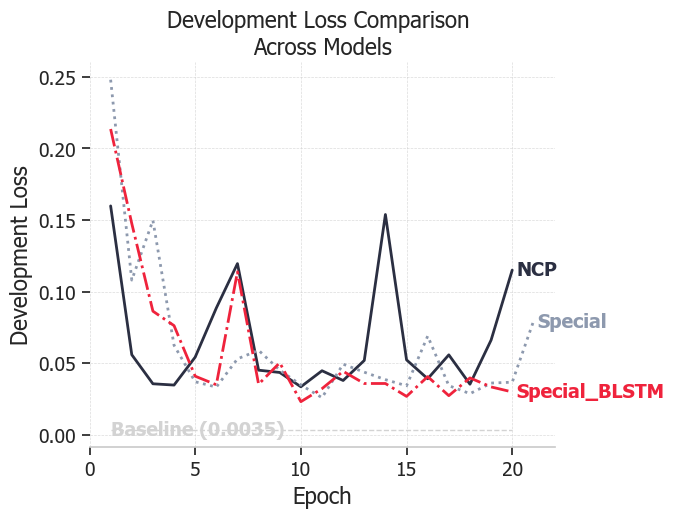

In [51]:
import matplotlib.pyplot as plt

# Assuming dev_losses is a dictionary with dev loss lists for each model
# Manually specify the model names you want to plot (keys from the dev_losses dictionary)
selected_models = ["C_SinglePoly_64_ncp_Au_dev_loss",
                    "D_SinglePoly_32_ncp_Special_Au_dev_loss",
                    "E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au_dev_loss"]

# Extract the selected models' dev losses
selected_dev_losses = [dev_losses[model] for model in selected_models]

# Define custom names for the models
custom_model_names = [ "NCP", "Special", "Special_BLSTM"]  # Customize based on your selected models

# Define a baseline, if you have one (otherwise, we can omit this part)
baseline = 0.0035  # Example baseline, adjust as needed

# ---------------- Plotting -----------------------
fig, ax = plt.subplots(figsize=(6, 5))

# -------------------BEGIN-CHANGES------------------------
# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Tahoma")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
# --------------------END CHANGES------------------------


x = list(range(1, len(selected_dev_losses[0]) + 1))


# Plot the baseline
ax.plot(
    [x[0], max(x)],
    [baseline, baseline],
    label="Baseline (0.0035)",
    color="lightgray",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    1.01,
    baseline,
    "Baseline (0.0035)",
    color="lightgray",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

# Define a nice color palette:
colors = ["black", "slateblue", "firebrick"]  # Adjust for the number of models
line_styles = ['-', 'dotted', 'dashdot']

# Plot each of the selected lines (for the picked models)
for i, label in enumerate(custom_model_names):
    # Create an x-axis based on the length of the current model's dev losses
    x = list(range(1, len(selected_dev_losses[i]) + 1))

    # Line
    ax.plot(x, selected_dev_losses[i], label=label, color=colors[i], linewidth=2, linestyle=line_styles[i])

    # Text for the final point
    ax.text(
        x[-1] * 1.01,
        selected_dev_losses[i][-1],
        label,
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# -------------------BEGIN-CHANGES------------------------
ax.set_xlabel("Epoch")  # Replace with the x-axis label
ax.set_ylabel("Development Loss")  # Replace with the y-axis label
# --------------------END CHANGES-------------------------
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


# Add a legend
# ax.legend()
plt.title("Development Loss Comparison \nAcross Models")


# Show the plot
plt.show()

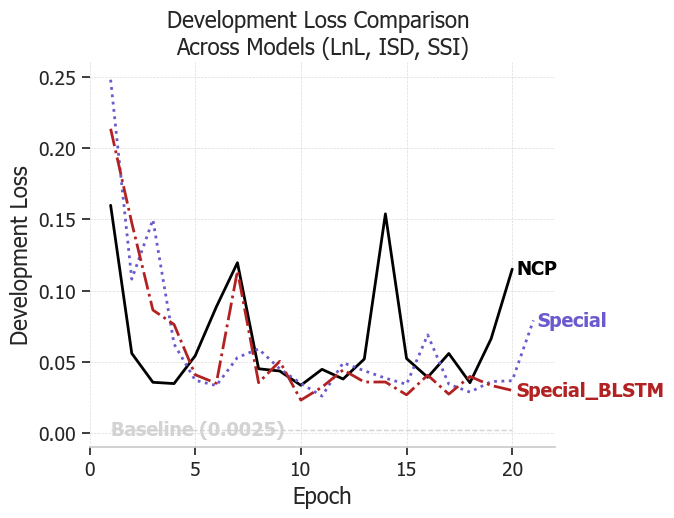

In [61]:
import matplotlib.pyplot as plt

# Assuming dev_losses is a dictionary with dev loss lists for each model
# Manually specify the model names you want to plot (keys from the dev_losses dictionary)
selected_models = ["C_SinglePoly_64_ncp_Au_dev_loss",
                    "D_SinglePoly_32_ncp_Special_Au_dev_loss",
                    "E_SinglePoly_32_ncp_Special_fourCONV2D_threeBLSTM_Au_dev_loss"]

# Extract the selected models' dev losses
selected_dev_losses = [dev_losses[model] for model in selected_models]

# Define custom names for the models
custom_model_names = [ "NCP", "Special", "Special_BLSTM"]  # Customize based on your selected models

# Define a baseline, if you have one (otherwise, we can omit this part)
baseline = 0.0023  # Example baseline, adjust as needed

# ---------------- Plotting -----------------------
fig, ax = plt.subplots(figsize=(6, 5))

# -------------------BEGIN-CHANGES------------------------
# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Tahoma")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
# --------------------END CHANGES------------------------

# Plot the baseline
ax.plot(
    [x[0], max(x)],
    [baseline, baseline],
    label="Baseline (0.0025)",
    color="lightgray",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    1.01,
    baseline,
    "Baseline (0.0025)",
    color="lightgray",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

# Define a nice color palette:
colors = ["black", "slateblue", "firebrick"]  # Adjust for the number of models
line_styles = ['-', 'dotted', 'dashdot']
# Plot each of the selected lines (for the picked models)
for i, label in enumerate(custom_model_names):
    # Create an x-axis based on the length of the current model's dev losses
    x = list(range(1, len(selected_dev_losses[i]) + 1))

    # Line
    ax.plot(x, selected_dev_losses[i], label=label, color=colors[i], linewidth=2, linestyle=line_styles[i])

    # Text for the final point
    ax.text(
        x[-1] * 1.01,
        selected_dev_losses[i][-1],
        label,
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# -------------------BEGIN-CHANGES------------------------
ax.set_xlabel("Epoch")  # Replace with the x-axis label
ax.set_ylabel("Development Loss")  # Replace with the y-axis label
# --------------------END CHANGES-------------------------
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


# Add a legend
# ax.legend()
plt.title("Development Loss Comparison \nAcross Models (LnL, ISD, SSI)")

# Show the plot
plt.show()

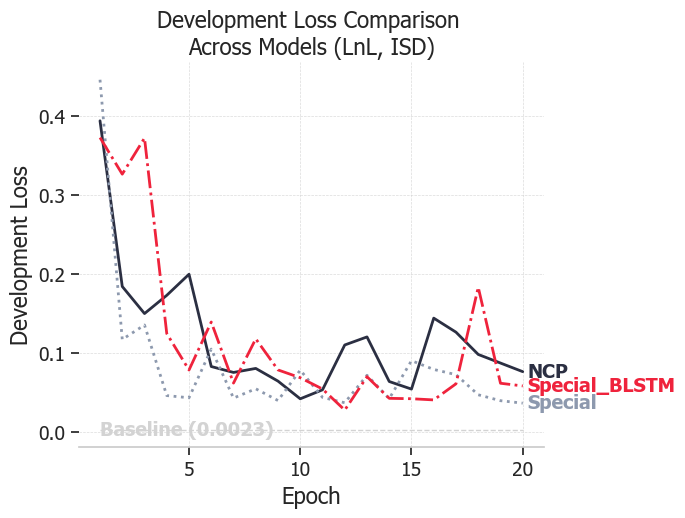

In [49]:
import matplotlib.pyplot as plt

# Assuming dev_losses is a dictionary with dev loss lists for each model
# Manually specify the model names you want to plot (keys from the dev_losses dictionary)
selected_models = [
                "C_ASV_NCP_32_Augment_5_dev_loss",
                "D_ASV_Special_32_Augment_5_logits_dev_loss",
                "E_ASV_Special_ThreeBLSTM_32_Augment_5_dev_loss"]

# Extract the selected models' dev losses
selected_dev_losses = [dev_losses[model] for model in selected_models]

# Define custom names for the models
custom_model_names = [ "NCP", "Special", "Special_BLSTM"]  # Customize based on your selected models

# Define a baseline, if you have one (otherwise, we can omit this part)
baseline = 0.0023  # Example baseline, adjust as needed

# ---------------- Plotting -----------------------
fig, ax = plt.subplots(figsize=(6, 5))

# -------------------BEGIN-CHANGES------------------------
# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Tahoma")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
# --------------------END CHANGES------------------------

# Plot the baseline
ax.plot(
    [x[0], max(x)],
    [baseline, baseline],
    label="Baseline (0.0023)",
    color="lightgray",
    linestyle="--",
    linewidth=1,
)

# Plot the baseline text
ax.text(
    1.01,
    baseline,
    "Baseline (0.0023)",
    color="lightgray",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
)

# Define a nice color palette:
colors = ["black", "slateblue", "firebrick"]  # Adjust for the number of models
line_styles = ['-', 'dotted', 'dashdot']
# Plot each of the selected lines (for the picked models)
for i, label in enumerate(custom_model_names):
    # Create an x-axis based on the length of the current model's dev losses
    x = list(range(1, len(selected_dev_losses[i]) + 1))

    # Line
    ax.plot(x, selected_dev_losses[i], label=label, color=colors[i], linewidth=2, linestyle=line_styles[i])

    # Text for the final point
    ax.text(
        x[-1] * 1.01,
        selected_dev_losses[i][-1],
        label,
        color=colors[i],
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Hide all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# -------------------BEGIN-CHANGES------------------------
ax.set_xlabel("Epoch")  # Replace with the x-axis label
ax.set_ylabel("Development Loss")  # Replace with the y-axis label
# --------------------END CHANGES-------------------------
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
# ax.legend()
plt.title("Development Loss Comparison \nAcross Models (LnL, ISD)")

# Show the plot
plt.show()

## Step 14: Going to the ASVspoof2021 repo

#### There are several changes that need to be implemented in the current ASVspood repository, in order to make it work and with more thna just the existing pre-trained model or toy_dataset.
Following are the changes we implemented:
* Put the folder "toy_dataset" in the DATA directory
* From toy_example remove the "download" part (since we alredy have the files)
* AFter you have run "02_toy_example" as it is ("/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/02_toy_example.sh"), it will have 
created the environment (pytorch-asvspoof2021)
* You can now also remove the first part of "02_toy_example" (all you need to do after that is activate the environment you created)

* In the "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/02_toy_example.sh", switch places of train and eval (first the model must be trained and then evaluated). The reason here it was the opposite is that by default the model takes data from an ALREADY trained model (it evaluates a pre-trained model and then trains a new one by using the pre-trained as an initialization)

* Move to "DF/Baseline-LFCC-LCNN/project/baseline_DF/config.py". 
 For training, change the tmp path so it lead to the correct dataset
 IMPORTANT! The format of the file in /DATA/ must follow the format of toy_dataset. By doing that, we can leave the rest of the file as it is (paths and variable names)

* Move to "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF/00_train.sh" (calls the main.py). The script by default uses the pre-trained model from ASVspoof2019. If you don't want to use it, just delete the option " --trained-model". Here, we can also set the prefered hyperparameters such as learning rate in the args section.

* Move to "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF/01_eval.sh" (VERY IMPORTANT). Since we are not going to use any pre-trained model, we need to change the path from (pretrained_model=__pretrained/trained_network.pt) to (trained_model=trained_network.pt). Through this ckeckpoint will our main.py be able to create the log_eval_score.txt (crusial fro evaluating our model later)


* A python path LOCATED IN in "/home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/env.sh" makes the higher repo "core-scripts" to be recognisable by lower directories like baseline_DF (main.py script). If we want to use "model.py --help" first we need to 
1) ACTIVATE THE ENV ---> conda ctivate pytorch-asvspoof2021
2) SET THE PYTHONPATH ---> PYTHONPATH=$PWD/../../:$PYTHONPATH python main.py --help. This commnad, sets the PYTHONPATH environment variable TEMPORARILY and then runs the main.py script with the --help option

* Make sure each time you change your dataset to erase the 3 dictionaries created at the start (otherwise you will get an errro during evaluation)

### QUALITY OF LIFE CHANGES

We make a script that, based on two files (trial_metadata.txt and log_eval_score.txt) can calculate the Equal Erro Rate of the model by finding the (the less, the better). This script calls another script made from the ASVspooo2021 located in "/home/stypsaltis/2021_Pnet/eval-package/archived-package-stage-1/DF/package-stage-1/evaluate.py".The metadata_file is the GROUNG TRUTH and need to be provided by the ASV (MUST be located in CM/trial_metadata.txt) and the score.txt is the file derived from training. The trial_metadata file must contain 8 columns (where the 2nd and 6th is the name of the LA_E_num flac file and the bonafide/spoof category respectfuly) and the score must contain 2 columns with the name of the LA_E_num flac file and the cm_score

* LA_0009 LA_E_1066571 alaw ita_tx A07 spoof notrim eval (MUST HAVE at leadt one spoof and one bonafide in order to work)
* LA_E_1066571 -1.188652

1) Create a script(.sh) named "run_python_script.sh"
2) Make it executable by running "chmod +x run_python_script.sh" (Neede only once)
3) Go IN the script you created and change the paths
4) Execute the script "./run_python_script.sh"


### MAKE EVAL-PACKAGE WORK

1) First you need to make sure that inside eval-package directory exists a file names "keys" that has ethe exact path of "keys < LA < CM < trial_metadata.txt" (They are the ground truth metadata)

2) Each line must have the format "LA_0009 LA_E_9332881 alaw ita_tx A07 spoof notrim eval"

3) Inside "keys" folder you MUST include an DF and PA folder (even if they are empty)

4) There alreadu exist pre-computed t-DCF C012 coefficients provided by the organizers which are neede in order to compute the EER (think of them as a cost fomrula where each type of spoof mismatch costs different)

In [ ]:
''' 
The PYTHONPATH is an environment variable used by the Python interpreter to determine which 
directories to search for modules and packages
'''

# SET THE PYTHON PATH ON LINUX
#export PYTHONPATH=$(pwd)
echo $PYTHONPATH # /home/stypsaltis/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF
export PYTHONPATH=$(pwd)/core_scripts#
echo $PYTHONPATH


#Alternatively, you can modify sys.path directly in your main.py script to include the path 
#to the core_scripts directory. Add this at the top of main.py:

import sys
import os

# Add the directory containing core_scripts to the Python path
cd ~/2021_Pnet/DF/Baseline-LFCC-LCNN/project/baseline_DF
sys.path.append(os.path.join(os.path.dirname(__file__), '../../core_scripts'))
PYTHONPATH=$PWD/../../:$PYTHONPATH python main.py --optimize 1 --optimizer 'Adam'


echo $PYTHONPATH

In [ ]:
# In order to run the models we need to 
# 1) Activate the envronment
# 2) Set the path to where the "02_toy_exmaple.sh" is located
# 3) Run the script
conda activate pytorch-asvspoof2021
# cd ~/2021_Pnet/DF/Baseline-LFCC-LCNN/project # Pnet model
cd ~/2021_Pnet/DF/Baseline-LFCC-LCNN/project # Pnet model
bash 02_toy_example.sh

### Create the flac folders with the augmenetd flac files

In [ ]:
#############################################
# Create the flac folder with train dataset #
#############################################


import os
import librosa
import numpy as np
# from RawBoost import process_Rawboost_feature
import soundfile as sf  # For saving augmented audio

# Set the directory paths
# Augmentation is applied to training data (but here we use both train and dev data for training
# so we will augment the dev too)
train_data_dir = 'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_train/flac/'  # Directory containing evaluation data
augmented_data_dir = 'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_train_aug/flac'  # Directory to save augmented data


# Make sure the augmented data directory exists
os.makedirs(augmented_data_dir, exist_ok=True)

# Get the list of audio files
file_list = [f for f in os.listdir(train_data_dir) if f.endswith('.flac')]

# Define the augmentation algorithm you want to use
# algo=1 for LnL convolutive noise, 2 for ISD, 3 for SSI, etc.
algo = 4  # For example, applying all 3 augmentations in series (LnL + ISD + SSI)

# Loop through each file, apply augmentation, and save the result
for file_name in file_list:
    # Load the audio file
    file_path = os.path.join(train_data_dir, file_name)
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Apply the RawBoost augmentation
    augmented_audio = process_Rawboost_feature(audio, sr, args, algo)
    
    # Normalize the augmented audio (optional but recommended)
    augmented_audio = augmented_audio / np.max(np.abs(augmented_audio))
    
    # Save the augmented audio to a new file
    save_path = os.path.join(augmented_data_dir, file_name.replace('.flac', '_aug.flac'))
    sf.write(save_path, augmented_audio, sr, format='FLAC')

    print(f"Saved augmented audio: {save_path}")

In [ ]:
###########################################
# Create the flac folder with dev dataset #
###########################################

import os
import librosa
import numpy as np
# from RawBoost import process_Rawboost_feature
import soundfile as sf  # For saving augmented audio

# Set the directory paths
# Augmentation is applied to training data (but here we use both train and dev data for training
# so we will augment the dev too)
dev_data_dir = 'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_dev/flac/'  # Directory containing evaluation data
augmented_data_dir = 'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_dev_aug/flac'  # Directory to save augmented data


# Make sure the augmented data directory exists
os.makedirs(augmented_data_dir, exist_ok=True)

# Get the list of audio files
file_list = [f for f in os.listdir(dev_data_dir) if f.endswith('.flac')]

# Define the augmentation algorithm you want to use
# algo=1 for LnL convolutive noise, 2 for ISD, 3 for SSI, etc.
algo = 4  # For example, applying all 3 augmentations in series (LnL + ISD + SSI)

# Loop through each file, apply augmentation, and save the result
for file_name in file_list:
    # Load the audio file
    file_path = os.path.join(dev_data_dir, file_name)
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Apply the RawBoost augmentation
    augmented_audio = process_Rawboost_feature(audio, sr, args, algo)
    
    # Normalize the augmented audio (optional but recommended)
    augmented_audio = augmented_audio / np.max(np.abs(augmented_audio))
    
    # Save the augmented audio to a new file
    save_path = os.path.join(augmented_data_dir, file_name.replace('.flac', '_aug.flac'))
    sf.write(save_path, augmented_audio, sr, format='FLAC')

    print(f"Saved augmented audio: {save_path}")


### In the augmenetd folder also copy the original files

In [ ]:
###############################################
# Copy the original flac file to the folder   #
# containig the augmented flac files (trains) #
###############################################
'''  
If the file doesn’t exist, it copies it from the original folder to the augmented 
folder using shutil.copy2(), which preserves file metadata (like timestamps).
'''
import os
import shutil

# Paths to the original and augmented folders
original_folder = r'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_train/flac'   # Path to the folder containing original flac files
augmented_folder = r'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_train_aug/flac'   # Path to the folder containing augmented flac files

# Ensure the augmented folder exists
os.makedirs(augmented_folder, exist_ok=True)

# Get the list of files in the original folder
original_files = [f for f in os.listdir(original_folder) if f.endswith('.flac')]

# Iterate over each original flac file
for file_name in original_files:
    # Construct the full file paths
    original_file_path = os.path.join(original_folder, file_name)
    augmented_file_path = os.path.join(augmented_folder, file_name)

    # Check if the file already exists in the augmented folder
    if not os.path.exists(augmented_file_path):
        # Copy the original file to the augmented folder
        shutil.copy2(original_file_path, augmented_file_path)
        print(f"Copied {file_name} to the augmented folder.")
    else:
        print(f"{file_name} already exists in the augmented folder. Skipping.")

print("File copying complete!")

In [ ]:
#############################################
# Copy the original flac file to the folder #
# containig the augmented flac files (dev)  #
#############################################
'''  
If the file doesn’t exist, it copies it from the original folder to the augmented 
folder using shutil.copy2(), which preserves file metadata (like timestamps).
'''
import os
import shutil

# Paths to the original and augmented folders
original_folder = r'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_dev/flac'   # Path to the folder containing original flac files
augmented_folder = r'C:/Users/User/Desktop/LA_2019/ASVspoof2019_LA_dev_aug/flac'   # Path to the folder containing augmented flac files

# Ensure the augmented folder exists
os.makedirs(augmented_folder, exist_ok=True)

# Get the list of files in the original folder
original_files = [f for f in os.listdir(original_folder) if f.endswith('.flac')]

# Iterate over each original flac file
for file_name in original_files:
    # Construct the full file paths
    original_file_path = os.path.join(original_folder, file_name)
    augmented_file_path = os.path.join(augmented_folder, file_name)

    # Check if the file already exists in the augmented folder
    if not os.path.exists(augmented_file_path):
        # Copy the original file to the augmented folder
        shutil.copy2(original_file_path, augmented_file_path)
        print(f"Copied {file_name} to the augmented folder.")
    else:
        print(f"{file_name} already exists in the augmented folder. Skipping.")

print("File copying complete!")

# Make it clear
### Train/Deb Dataset 2019 (LA.zip) from https://datashare.ed.ac.uk/handle/10283/3336
### Dev Dataset 2021 (Speech_Data/LA subset) from https://zenodo.org/records/4837263
### Dev Dataset 2021 (LA keys and metadata) from https://www.asvspoof.org/index2021.html